# Basket CDS Pricing


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
import time
from scipy.special import gamma, betaincinv, betainc
import seaborn as sns
import QuantLib as ql
import warnings
import yfinance as yf
from scipy.special import gamma
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')

# Auxilary functions

In [38]:
class Interpolation:
    """
    Class to interpolate data either piecewise or linearly.
    """
    def __init__(self, x, y):
        
        self.x = np.array(x)
        self.y = np.array(y)
        

    def get_raw_interpolation(self, dt):
        
        """
        x: tenor
        y: discount Factor // zcb
        ------------------
        output: 
        tenor, DF, zero rates, forward rate
        -------------------
        NB: raw interpolation has a constant forward rate (for interpolated points)
        FWD are not continuous
        """
        

        tenor = self.x
        rt = -np.log(self.y) # -log(DF) = r(t)t
        
        mat = np.arange(min(tenor), max(tenor)+dt, dt)
        new_rt = np.zeros(len(mat)) # interp r(t)t
        
        idx0 = 0
        new_rt[0] = 0.0 # at time 0 interest rate = 0
        for i in range(1,len(mat)):
            if mat[i] in tenor: # 
                #idx0 = tenor.index(mat[i])
                idx0 = np.where(tenor == mat[i])[0][0]
                new_rt[i] = rt[idx0]

            else:
                
                new_rt[i] = self.linear_interpolation(tenor[idx0], tenor[idx0+1],
                                                        rt[idx0], rt[idx0+1],
                                                        mat[i])
                
        DF = np.exp(-new_rt)
        zeros = np.append([0], new_rt[1:]/ mat[1:])
        
        frac = (DF[:-1]/DF[1:])
    
               
        fwd = 1/(mat[1:]-mat[:-1]) * np.log(frac)
        fwd = np.append([0], fwd)
    
        
        return mat, DF, zeros, fwd
                
        
    
    def get_interpolation(self, dt):
        
        """
        Variation of the code above to interpolate CDS Spread
        x: tenor
        y: spread
        ------------------
        output: 
        tenor,spread
        -------------------
        """
        

        tenor = self.x
        cds = self.y # -log(DF) = r(t)t

        
        mat = np.append([0],np.arange(min(tenor), max(tenor)+dt, dt))
        new_cds = np.zeros(len(mat)) #
        
        idx0 = 0
    
        new_cds[0] = 0.0 # at time 0 spread = 0
        for i in range(1,len(mat)):
            
            if mat[i] in tenor: # 
                #idx0 = tenor.index(mat[i])
                idx0 = np.where(tenor == mat[i])[0][0]
                new_cds[i] = cds[idx0]

            else:

                new_cds[i] = self.linear_interpolation(tenor[idx0], tenor[idx0+1],
                                                        cds[idx0], cds[idx0+1],
                                                        mat[i])
                
        
        return mat, new_cds
    
    def get_piecewise(self, k):
        
        """
        input: k: scalar.
        compare k with the x array
        """
        
        n = len(self.x)
        if k<=self.x[0]:
            return self.y[0]
        for i in range(1,n):
            if (k>self.x[i-1]) and k<=self.x[i]:
                return self.y[i]
        return self.y[-1]
            
    
    def get_linear(self, k):
        """input: k: scalar"""
        
        if k <self.x[0] or k > self.x[-1]:
            print(k, " is out of range (i.e. extrapolation!).")
        
        n = len(self.x)
        
        if k == self.x[0]: # check left bondary
            return self.y[0]
        for i in range(1,n):
            if k ==self.x[i]:
                return self.y[i]
            elif k>self.x[i-1] and k<self.x[i]:
                return self.linear_interpolation(self.x[i-1], self.x[i],
                                                 self.y[i-1], self.y[i], k)
    
    
    
    def plot_piecewise(self):
        """
        Function to plot a piecewise function
        x: np.series
        y: np.seris
        return a plot
        """

        plt.plot(self._repeat(self.x)[:-1], self._repeat(self.y)[1:])
        
        
    def plot_linear(self):
        
        plt.plot(self.x, self.y)
        
    @staticmethod
    def _repeat(l, k=2):
        """
        input:
        l: list - e.g. [1,2,3]
        k: number of time elements needs to be return
        output: 
        new list with element duplicated k time. 
        by default repeat each element twice. (k=2).
        """
        new = []

        for i in l:
            for j in range(k):
                new.append(i)
        return new
    
    @staticmethod
    def linear_interpolation(x0,x1,y0,y1,xp):
        """
        Linear interpolation between two points:
        Using equation of a straight line between
        two points.
        ------------------------------------------
        x0, y0: Initional point on the x-axis, y-axis
        x1, y1: Final point on the x-axis, y-axis
        xp: Intermediate point
        """
        return y0+ (y1-y0)/(x1-x0) * (xp-x0)
        
            

In [39]:
def linear_interpolation(x,y, t):
    
    """
    1D interpolation
    ------------------------------------------------
    x: array
    y: array
    t: point
    
    to review (different implementation to check speed)
    """
    
    
    x, y = np.array(x).reshape(-1,1), np.array(y).reshape(-1,1)

    # Get the neighbor values
    t1 =np.amax(x[x<=t], initial=x.min())
    t2= np.amin(x[t<=x], initial = x.max())
    

    if t in x:
    
        return y[np.where(x==t)[0][0]]
    # Interpolate the values

    return y[np.where(x==t1)[0][0]] + (y[np.where(x==t2)[0][0]]-y[np.where(x==t1)[0][0]])/(x[np.where(x==t2)[0][0]]-x[np.where(x==t1)[0][0]])* (t-x[np.where(x==t1)[0][0]])

In [40]:
def zcb(T):
    """
    input : T: Scalar : Maturity
    -----------------------------
    Output: Zero Coupon Bond <==> Discount Factor
    -----------------------------
    NB: in this case, t: 0. 
    Therefore, there is no need to explicitly call it. 
    """
    if T > np.max(DF_data.loc[:,"T"]):
        return np.min(DF_data.loc[:,"DF"])
    return linear_interpolation(DF_data.loc[:,"T"], DF_data.loc[:,"DF"],T)

In [41]:
def norm_pdf(x):
    """
    Standard normal probability density function
    """
    return (1.0/((2*np.pi)**0.5))*np.exp(-0.5*x**2)

#### Norm cdf

In [42]:
def norm_cdf(x):
    """
    Norm CDF function # Wilmott Magazine, p 70-76, May 2005 # Graeme West
    Hart (1968)
    """
    x_abs = abs(x)
    
    if x_abs > 37:
        norm_cdf = 0
    else:
        exp_abs = np.exp(-0.5*x_abs**2)
        
        if x_abs < 7.07106781186547:
            k_temp = 3.52624965998911E-02 * x_abs + 0.700383064443688
            k_temp = k_temp * x_abs + 6.37396220353165
            k_temp = k_temp * x_abs + 33.912866078383
            k_temp = k_temp * x_abs + 112.079291497871
            k_temp = k_temp * x_abs + 221.213596169931
            k_temp = k_temp * x_abs + 220.206867912376
            
            
            norm_cdf = exp_abs * k_temp        
            
            
            k_temp = 8.83883476483184E-02 * x_abs + 1.75566716318264
            k_temp = k_temp * x_abs + 16.064177579207
            k_temp = k_temp * x_abs + 86.7807322029461
            k_temp = k_temp * x_abs + 296.564248779674
            k_temp = k_temp * x_abs + 637.333633378831
            k_temp = k_temp * x_abs + 793.826512519948
            k_temp = k_temp * x_abs + 440.413735824752
            norm_cdf = norm_cdf / k_temp
            
            
            
        else:
            k_temp = x_abs + 0.65
            k_temp = x_abs + 4 / k_temp
            k_temp = x_abs + 3 / k_temp
            k_temp = x_abs + 2 / k_temp
            k_temp = x_abs + 1 / k_temp
            norm_cdf = exp_abs / k_temp / 2.506628274631

    if x > 0:
        norm_cdf = 1 - norm_cdf

    return norm_cdf
    

##### Vectorisation

The vectorize function is provided primarily for convenience, not for performance. The implementation is essentially a for loop.


In [43]:
# vectorise norm_cdf function
norm_cdf_v = np.vectorize(norm_cdf)

#### Norm Inv

In [44]:
def norm_inv(p):
#   Onverse normal algorithm developed by
#   P. J. Acklam.  It is accurate to 1.15E-9.
#   Could not find the original paper online. # Website link does not exist anymore. 
#   Used this as a reference. https://stackedboxes.org/2017/05/01/acklams-normal-quantile-function/

    #Define constants
    a1  = -39.6968302866538   
    a2  = 220.946098424521     
    a3  = -275.928510446969    
    a4  = 138.357751867269     
    a5  = -30.6647980661472    
    a6  = 2.50662827745924    
    
    b1  = -54.4760987982241     
    b2  = 161.585836858041     
    b3  = -155.698979859887    
    b4  = 66.8013118877197     
    b5  = -13.2806815528857    
    
    c1  = -7.78489400243029*10**(-3) 
    c2  = -0.322396458041136    
    c3  = -2.40075827716184     
    c4  = -2.54973253934373    
    c5  = 4.37466414146497      
    c6  = 2.93816398269878      
    
    d1  = 7.78469570904146*10**(-3)  
    d2  = 0.32246712907004      
    d3  = 2.445134137143        
    d4  = 3.75440866190742 
    
    #Define break points
    p_lower  = 0.02425 # lower bound
    p_upper  = 1 - p_lower  # upper bound
    
    
    if (0 < p < p_lower): #Rational approximation for lower region
        q = (-2 * np.log(p))**0.5
        norm_inverse = (((((c1 * q + c2) * q + c3) * q + c4) * q + c5) * q + c6) / ((((d1 * q + d2) * q + d3) * q + d4) * q + 1)
        
    elif (p_lower <p< p_upper): #Rational approximation for central region
        q = p - 0.5
        r = q * q
        norm_inverse = (((((a1 * r + a2) * r + a3) * r + a4) * r + a5) * r + a6) * q /(((((b1 * r + b2) * r + b3) * r + b4) * r + b5) * r + 1)
    elif (p_upper < p) and (p < 1): #Rational approximation for upper region
        q = (-2 * np.log(1 - p))**0.5
        norm_inverse = -(((((c1 * q + c2) * q + c3) * q + c4) * q + c5) * q + c6) /((((d1 * q + d2) * q + d3) * q + d4) * q + 1)
    else: #Out of valid region
        norm_inverse = np.log(-1) #invalid value

        
    return norm_inverse

In [45]:
# vectorise norm_cdf function
norm_inv_v = np.vectorize(norm_inv)

### t-student

#### Beta functions

In [46]:
from scipy.special import betainc

In [47]:
def beta(a,b):
     
     
    return gamma(a)*gamma(b)/gamma(a+b)
    

In [48]:
def beta_inc_lower(a,b,x):
    


    return betainc(a,b,x)* beta(a,b)
    


#### PDF

In [49]:
def t_student_pdf(t, nu):
    a = (nu+1)/2
    
    return gamma(a)/(np.sqrt(nu*np.pi)*gamma(nu/2))*(1+t**2/nu)**(-a)

#### CDF

In [50]:
def t_student_cdf(x, nu):
    
    """
    t_student cdf:
    ------------------------
    input: x : nx1 array
           nu: degree of freedom 
    """
    
    x = np.array(x)
    x = x.reshape(-1,1)
    c = nu / (nu+x**2)  
    #cdf =  0.5 * rl_beta_inc(nu/2, 0.5, c)
    cdf =  0.5 * betainc(nu/2, 0.5, c)
    
    # psi(x) = 1-psi(-x)
    # please note x**2 = (-x)**2
    # hence we can just return 1-cdf
    cdf = cdf.T
    return np.select(x.T <=np.zeros_like(x.T), cdf, 1-cdf).T
#     if x <=0:
#         return cdf
#     else: 
#         return 1-cdf

#### Inverse

In [51]:
from scipy.special import betaincinv

In [52]:
def t_student_inv(p, nu):
    """
    input: nx1 array
           nu: scalar: degree of freedom
    ----------------------------------------
    output: nx1 array
    ----------------------------------------
    Source: MyTINV p17: T COPULA and degrees of freedom \nu (MLE PROCEDURE GUIDE)
    
    Formula coherent with 
    https://www.wolframalpha.com/input/?i=inverse+cdf+student%27s+t+distribution    
    """
    p = np.array(p).reshape(-1,1)
    
        
        
    var = np.minimum(p, 1-p)
    temp = betaincinv( nu/2, 0.5, 2*var)
    try:
        temp = 1/temp
    except (RuntimeError, RuntimeWarning):
        print("Oops!  Dividing by 0 !?")
        temp =np.inf
    
    x = np.sign(p-0.5)*(nu*(temp-1))**0.5
    return x

# Importing data and data cleaning
Data source: https://www.kaggle.com/datasets/debashish311601/credit-default-swap-cds-prices/data

In [53]:
data = pd.read_csv('cds.csv', sep = ',', index_col=0)
data = data.drop(columns= 'Company')

We are going to use WFC (Wells Fargo), BAC (bank of america), UBS, MS, BACR (Barclays) as reference entities. These are all banks from the US and the UK. 

In [54]:
Tickers = ['WFC', 'BAC', 'UBS', 'MS', 'BACR']
data = data.loc[data['Ticker'].isin(Tickers)]
data

Ticker      PX1      PX2      PX3      PX4      PX5      PX6  \
Date                                                                      
2015-01-01    BAC  22.9600  31.9950  42.0950  51.1800  67.7800  80.7500   
2015-01-02    BAC  23.1600  32.2200  42.2900  51.7050  67.6300  80.7500   
2015-01-05    BAC  23.2200  32.4300  42.5200  52.1150  70.1950  81.0750   
2015-01-06    BAC  23.9150  33.9750  44.0950  53.1800  69.6700  83.7200   
2015-01-07    BAC  23.9250  32.9800  43.0950  52.1900  68.7800  81.9000   
...           ...      ...      ...      ...      ...      ...      ...   
2021-09-06    WFC  24.0602  28.4470  32.4739  37.5340  42.9102  50.9026   
2021-09-07    WFC  23.0469  27.0686  31.2598  36.6238  42.9493  50.8743   
2021-09-08    WFC  22.2302  26.4456  30.5631  36.5802  42.8433  50.8281   
2021-09-09    WFC  24.4325  28.1366  32.4024  36.4395  42.4928  50.1988   
2021-09-10    WFC  23.4124  27.7391  31.8399  36.4562  42.0503  50.0410   

                PX7      PX8       PX9      PX10  
Date                                              
2015-01-01  90.6500  96.8000  101.5950  105.3950  
2015-01-02  90.6500  97.2700  102.4300  106.5200  
2015-01-05  91.3900  97.9600  103.0800  107.1450  
2015-01-06  93.6050  99.7450  104.5350  108.3350  
2015-01-07  91.7950  98.1650  103.1250  107.0600  
...             ...      ...       ...       ...  
2021-09-06  56.5026  61.1432   64.7042   67.5218  
2021-09-07  56.4210  61.1756   64.8200   67.7002  
2021-09-08  56.4139  60.9077   64.3527   67.0756  
2021-09-09  55.5909  60.6176   64.4691   67.5118  
2021-09-10  55.6287  60.8002   64.7608   67.8888  

[8046 rows x 11 columns]

In [55]:
BAC_df = data.loc[data['Ticker']=='BAC']
WFC_df = data.loc[data['Ticker']=='WFC']
UBS_df = data.loc[data['Ticker']=='UBS']
MS_df = data.loc[data['Ticker']=='MS']
BACR_df = data.loc[data['Ticker']=='BACR']

BACR_df.iloc[-1,:]

Ticker       BACR
PX1       18.0754
PX2       27.4005
PX3       30.3782
PX4       38.7944
PX5       47.4815
PX6       56.7196
PX7       63.1979
PX8       68.8727
PX9       73.2224
PX10       76.658
Name: 2021-09-10, dtype: object

In [56]:
BACR_df['PX10']

Date
2015-02-24     99.2050
2015-02-25    102.6050
2015-02-26     94.7550
2015-02-27     99.0350
2015-03-02     97.6400
                ...   
2021-09-06     77.5072
2021-09-07     79.5427
2021-09-08     79.2998
2021-09-09     78.3436
2021-09-10     76.6580
Name: PX10, Length: 1709, dtype: float64

<Axes: title={'center': 'Historical CDS spreads 10Y'}, xlabel='Date', ylabel='Spreads in bps'>

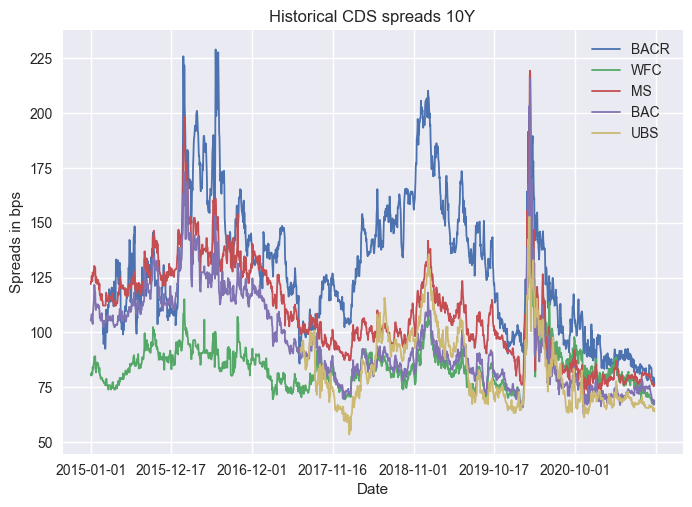

In [57]:
d = {}
d['BACR'] = BACR_df['PX10']
d['WFC'] = WFC_df['PX10']
d['MS'] = MS_df['PX10']
d['BAC'] = BAC_df['PX10']
d['UBS'] = UBS_df['PX10']

d = pd.DataFrame(d)
d.plot(title = 'Historical CDS spreads 10Y', ylabel = 'Spreads in bps', lw = 1.3)

<Axes: title={'center': 'Historical 10Y CDS spreads changes'}, xlabel='Date', ylabel='Spreads in bps'>

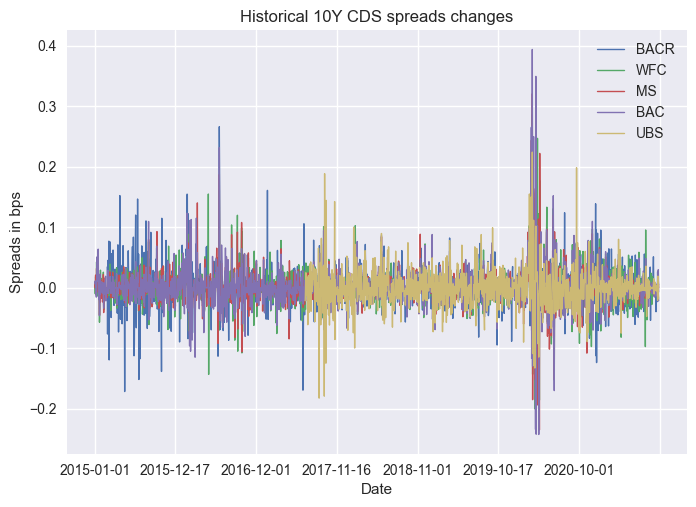

In [58]:
d.pct_change().plot(title = 'Historical 10Y CDS spreads changes', ylabel = 'Spreads in bps', lw = 1)

We are going to focus on the last known data: 2021-09-10.

In [59]:
Tickers = ['WFC', 'BAC', 'UBS', 'MS', 'BACR']
cds_spread = {}
cds_spread['WFC'] = WFC_df.iloc[-1,:]
cds_spread['BAC'] = BAC_df.iloc[-1,:]
cds_spread['UBS'] = UBS_df.iloc[-1,:]
cds_spread['MS'] = MS_df.iloc[-1,:]
cds_spread['BACR'] = BACR_df.iloc[-1,:]
cds_spread = pd.DataFrame(cds_spread).T
cds_spread = cds_spread.drop(columns='Ticker')
cds_spread.index = Tickers
cds_spread.index.name = 'Company'
cds_spread.columns = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y']
cds_spread

1Y       2Y       3Y       4Y       5Y       6Y       7Y  \
Company                                                                  
WFC      23.4124  27.7391  31.8399  36.4562  42.0503   50.041  55.6287   
BAC      23.9441  27.0477  31.2963  36.3222  41.7542  50.3954  56.4366   
UBS      13.7758  18.9824  25.8932  32.6657   39.958  47.9372  53.5364   
MS       26.7402  33.2323  38.7523  43.9878  50.2984  61.5069  69.3312   
BACR     18.0754  27.4005  30.3782  38.7944  47.4815  56.7196  63.1979   

              8Y       9Y      10Y  
Company                             
WFC      60.8002  64.7608  67.8888  
BAC       61.568  65.4994  68.6051  
UBS       57.971  61.3738  64.0641  
MS       72.2901   74.563  76.3624  
BACR     68.8727  73.2224   76.658

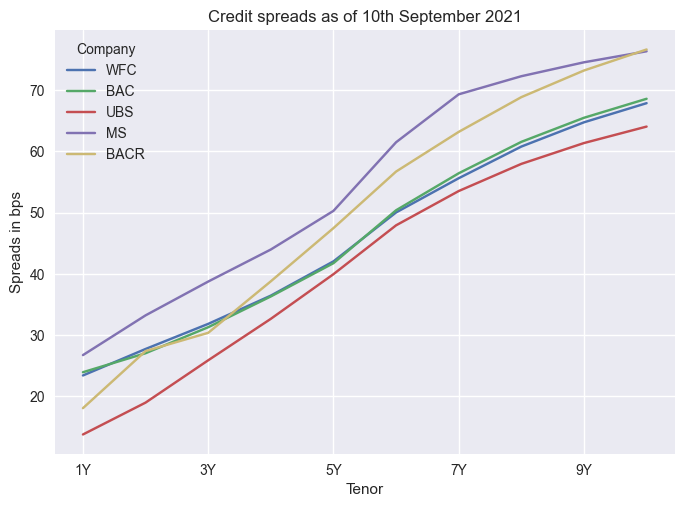

In [60]:
cds_spread.T.plot(title=  'Credit spreads as of 10th September 2021', xlabel = 'Tenor', ylabel = 'Spreads in bps');

# Discount Factor

We will use the US treasury curve from 2021-09-10 to obtain discount facotrs. We will suppose that all companies are located in the US (which is not the case for Barclays, UBS and Wells Fargo)

In [61]:
yield_curve = pd.read_csv('daily-treasury-rates.csv', sep = ',', index_col = 0)
yield_curve = yield_curve.drop(columns=['1 Mo', '2 Mo', '3 Mo','6 Mo','20 Yr', '30 Yr'])
yield_curve

1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr
Date                                           
12/31/2021  0.39  0.73  0.97  1.26  1.44   1.52
12/30/2021  0.38  0.73  0.98  1.27  1.44   1.52
12/29/2021  0.38  0.75  0.99  1.29  1.47   1.55
12/28/2021  0.39  0.74  0.99  1.27  1.41   1.49
12/27/2021  0.33  0.76  0.98  1.26  1.41   1.48
...          ...   ...   ...   ...   ...    ...
01/08/2021  0.10  0.14  0.24  0.49  0.81   1.13
01/07/2021  0.11  0.14  0.22  0.46  0.78   1.08
01/06/2021  0.11  0.14  0.20  0.43  0.74   1.04
01/05/2021  0.10  0.13  0.17  0.38  0.66   0.96
01/04/2021  0.10  0.11  0.16  0.36  0.64   0.93

[251 rows x 6 columns]

Interpolate for 4Y, 6Y and 8Y

In [62]:
yield_curve['4 Yr'] = np.NaN
yield_curve['6 Yr'] = np.NaN
yield_curve['8 Yr'] = np.NaN
yield_curve['9 Yr'] = np.NaN
yield_curve = yield_curve[['1 Yr', '2 Yr', '3 Yr', '4 Yr', '5 Yr', '6 Yr', '7 Yr', '8 Yr', '9 Yr', '10 Yr']]
yield_curve = yield_curve.interpolate(axis = 1)
yield_curve = yield_curve.sort_index()

Selecting the Yield Curve from 2021-09-10

In [63]:
yield_curve = yield_curve[yield_curve.index== '09/10/2021']
yield_curve

1 Yr  2 Yr  3 Yr   4 Yr  5 Yr  6 Yr  7 Yr      8 Yr      9 Yr  \
Date                                                                        
09/10/2021  0.08  0.23  0.45  0.635  0.82  0.97  1.12  1.196667  1.273333   

            10 Yr  
Date               
09/10/2021   1.35

Converting maturities to numerical values

In [64]:
Tenors = []
for i in yield_curve.columns:
    Tenors.append(int(i[:-3]))
yield_curve.columns = Tenors
yield_curve

1     2     3      4     5     6     7         8         9   \
Date                                                                        
09/10/2021  0.08  0.23  0.45  0.635  0.82  0.97  1.12  1.196667  1.273333   

              10  
Date              
09/10/2021  1.35

<Axes: title={'center': 'Yield Curve'}, xlabel='Tenor', ylabel='Interest rate'>

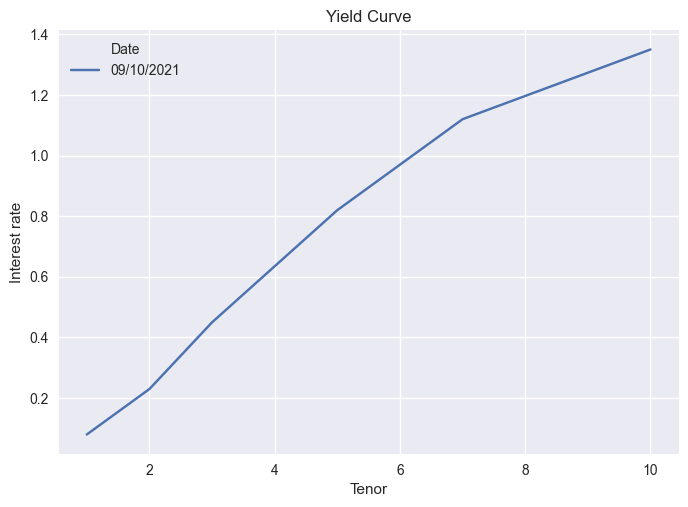

In [65]:
yield_curve.T.plot(title = 'Yield Curve', xlabel = 'Tenor', ylabel = 'Interest rate')

We obtain the Discount factors for each maturity

In [66]:
DF = []
rates = yield_curve.iloc[0]
for i, T in zip(rates,Tenors):
    df = 1/((1+i/100)**T)
    DF.append(df)
DF = pd.DataFrame(DF)
DF.index = Tenors
DF.columns = ['DF']
DF

DF
1   0.999201
2   0.995416
3   0.986621
4   0.974998
5   0.959990
6   0.943726
7   0.924998
8   0.909223
9   0.892368
10  0.874505

<Axes: title={'center': 'Discount factor curve'}>

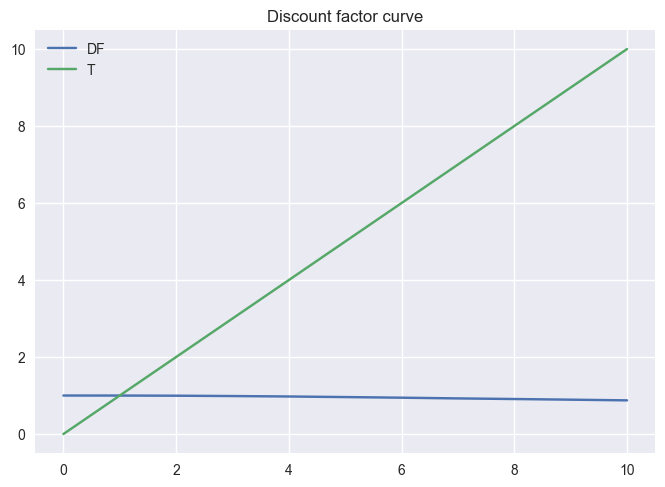

In [67]:
DF_data = DF.copy()
DF_data['T'] = np.arange(1,11)
DF_data.loc[0] = [1,0]
DF_data = DF_data.sort_index()
DF_data.plot(title = 'Discount factor curve')

<Axes: title={'center': 'Discount factor curve'}>

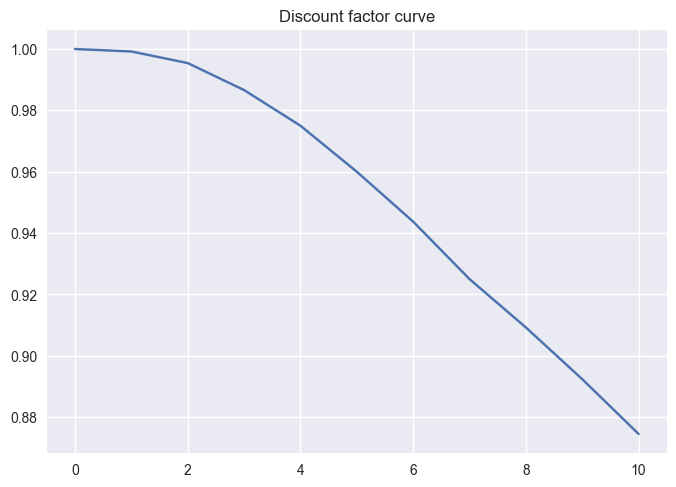

In [68]:
DF_data['DF'].plot(title = 'Discount factor curve')

Interpolate discount factors

<Axes: title={'center': 'Discount factor curve'}, xlabel='Tenor', ylabel='Discount factor'>

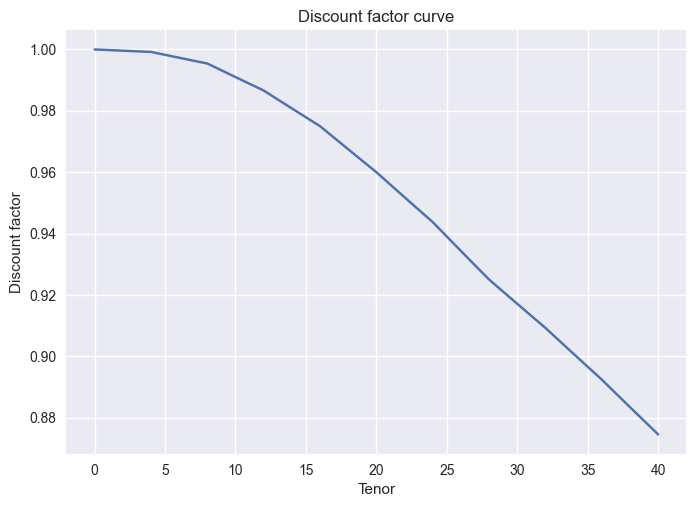

In [69]:
dt = 0.25
interp = Interpolation(DF_data['T'], DF_data['DF'])

Discount_factors = pd.DataFrame(interp.get_raw_interpolation(dt)).T
Discount_factors.columns = ["T", "DF", "r", "fwd"]
Discount_factors['DF'].plot(title = 'Discount factor curve', xlabel = 'Tenor', ylabel = 'Discount factor')

In [70]:
Discount_factors.index = np.arange(0, 10.25, 0.25)

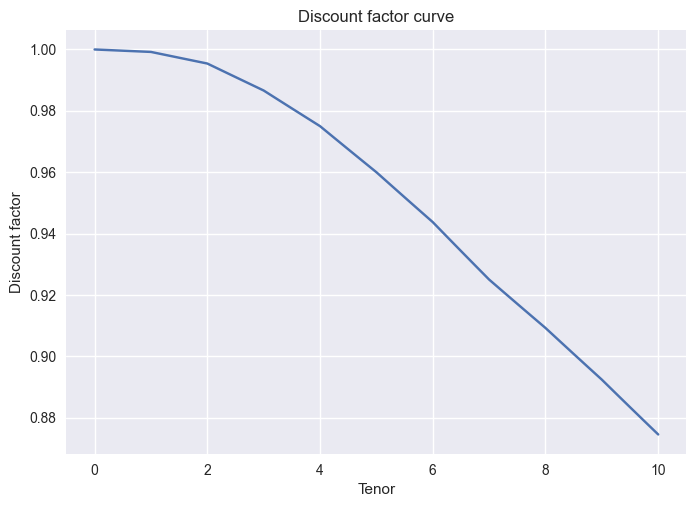

In [71]:
Discount_factors['DF'].plot(title = 'Discount factor curve', ylabel = 'Discount factor', xlabel = 'Tenor');

# Survival probabilities

file:///C:/Users/andri/Downloads/SSRN-id2042177.pdf
http://www.angelvila.eu/documents/CREDITMETRICSDOCUMENTOTECNICO_000.pdf
https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=cfcfaee78a78c8f0533bc7cceddb84b83cb1e919


In [72]:
def survival_probability(maturity, spread, DF, RR = 0.4):
    
    """
    JPM Implementation: 
    Maturity: in year np.array / list
    Spread: array / list of CDS spread
    DF: Discount Factor: np.array / list
    RR: Recovery Rate (float)
    --------------------------------------
    Return: survival probability and hazard rate.
    """
    
    
    maturity = np.array(maturity, dtype = int)
    if maturity[0]!=0:
        maturity = np.append([0], maturity)
    

    dt = np.append([0],np.diff(maturity)) 
    
    #Spread
    spread = np.array(spread)
    if spread[0] != 0:
        spread = np.append([0], spread)
    if spread[1] > 1:
        spread = spread/10000 # convert spread into decimals
    
    n = len(maturity)

    
    DF = np.array(DF)
    survival = np.zeros(n)
    survival[0] = 1.0
    
    
    
    # Loss Rate = (1 - Recovery Rate)
    L = (1-RR)
    
    
    # i=1
    #survival[1] = (L-0.5*spread[1] *dt[1])/ (0.5*spread[1] *dt[1] + L) # for accrued n = 1 
    survival[1] = L/ (spread[1] *dt[1] + L) 
    

    for i in range(2,n):

        # List comprehension to improve speed
        # S (Summation Term)
        S = [DF[j] * (L * survival[j-1] - \
                          (L + dt[j] * spread[i])* \
                           survival[j]) for j in range(1,i)]
        
            
        denominator = DF[i]*( L +dt[i]*spread[i])
        last = (L*survival[i-1] / ( L + dt[i] * spread[i]))


        survival[i] = sum(S) / denominator + last
    
    
    lambdas = np.zeros(len(survival))

    for i in range(1, len(survival)):
        lambdas[i] = -1 / dt[i] * np.log(survival[i] / survival[i-1])
        
    

    return survival, lambdas

In [73]:
cds_spread.columns = Tenors
cds_spread.insert(0, '0', np.zeros(5))
cds_spread

0        1        2        3        4        5        6        7  \
Company                                                                       
WFC      0.0  23.4124  27.7391  31.8399  36.4562  42.0503   50.041  55.6287   
BAC      0.0  23.9441  27.0477  31.2963  36.3222  41.7542  50.3954  56.4366   
UBS      0.0  13.7758  18.9824  25.8932  32.6657   39.958  47.9372  53.5364   
MS       0.0  26.7402  33.2323  38.7523  43.9878  50.2984  61.5069  69.3312   
BACR     0.0  18.0754  27.4005  30.3782  38.7944  47.4815  56.7196  63.1979   

               8        9       10  
Company                             
WFC      60.8002  64.7608  67.8888  
BAC       61.568  65.4994  68.6051  
UBS       57.971  61.3738  64.0641  
MS       72.2901   74.563  76.3624  
BACR     68.8727  73.2224   76.658

In [74]:
DF = DF.T

In [75]:
DF.insert(0, '0', 1)
Tenors = np.arange(11)
DF = DF.T
DF = np.array(DF)

## Calculate Survival Probabilities

In [76]:
surv_lbd= {}
for name in cds_spread.index:
    surv = []
    lbd = []
    cds = cds_spread.loc[name,:]
    surv, lbd = survival_probability(Tenors, cds, DF, 0.4)
    surv_lbd[name] = np.array([Tenors, surv, lbd])

In [77]:
surv_lbd['BAC'].shape

(3, 11)

Survival Probability Matrix

In [78]:
survival_probs = {}
for name in cds_spread.index:
    survival_probs[name] = surv_lbd[name][1]
survival_probs = pd.DataFrame(survival_probs)
survival_probs.T

0         1         2         3         4         5         6   \
WFC   1.0  0.996113  0.990811  0.984216  0.975956  0.965398  0.950652   
BAC   1.0  0.996025  0.991040  0.984483  0.976037  0.965635  0.950280   
UBS   1.0  0.997709  0.993696  0.987118  0.978365  0.966970  0.952536   
MS    1.0  0.995563  0.989004  0.980823  0.971067  0.958764  0.939602   
BACR  1.0  0.996996  0.990916  0.984932  0.974381  0.960889  0.944089   

            7         8         9         10  
WFC   0.936205  0.920625  0.905356  0.890370  
BAC   0.935247  0.919609  0.904282  0.889239  
UBS   0.938371  0.924071  0.910028  0.896223  
MS    0.920924  0.906448  0.892229  0.878249  
BACR  0.927644  0.910354  0.893436  0.876864

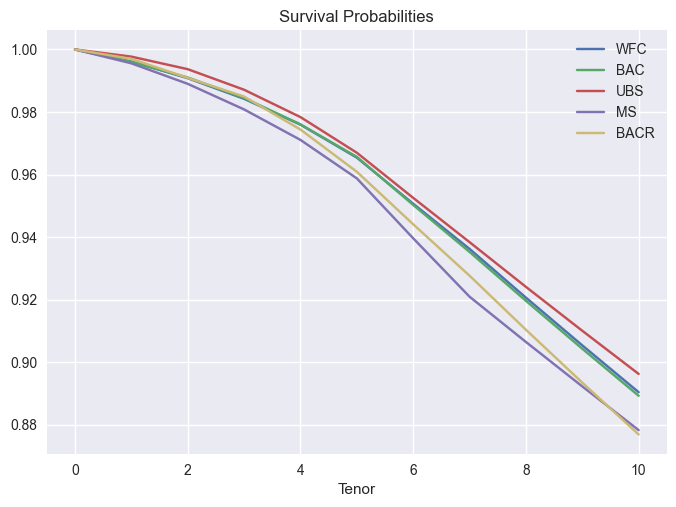

In [79]:
survival_probs.plot(title = 'Survival Probabilities', xlabel = 'Tenor');

In [80]:
default_intensities = {}
for name in cds_spread.index:
    default_intensities[name] = surv_lbd[name][2]
default_intensities = pd.DataFrame(default_intensities)
default_intensities.T * 100

0         1         2         3         4         5         6   \
WFC   0.0  0.389447  0.533665  0.667902  0.842778  1.087670  1.539242   
BAC   0.0  0.398274  0.501719  0.663867  0.861581  1.071483  1.602938   
UBS   0.0  0.229333  0.403018  0.664224  0.890701  1.171514  1.503927   
MS    0.0  0.444680  0.661016  0.830580  0.999713  1.275088  2.018801   
BACR  0.0  0.300804  0.611766  0.605717  1.076958  1.394410  1.763804   

            7         8         9         10  
WFC   1.531361  1.678173  1.672442  1.669118  
BAC   1.594550  1.686258  1.680734  1.677519  
UBS   1.498232  1.535721  1.531346  1.528622  
MS    2.007936  1.584309  1.581130  1.579310  
BACR  1.757239  1.881463  1.875861  1.872364

In [81]:
default_intensities

WFC       BAC       UBS        MS      BACR
0   0.000000  0.000000  0.000000  0.000000  0.000000
1   0.003894  0.003983  0.002293  0.004447  0.003008
2   0.005337  0.005017  0.004030  0.006610  0.006118
3   0.006679  0.006639  0.006642  0.008306  0.006057
4   0.008428  0.008616  0.008907  0.009997  0.010770
5   0.010877  0.010715  0.011715  0.012751  0.013944
6   0.015392  0.016029  0.015039  0.020188  0.017638
7   0.015314  0.015945  0.014982  0.020079  0.017572
8   0.016782  0.016863  0.015357  0.015843  0.018815
9   0.016724  0.016807  0.015313  0.015811  0.018759
10  0.016691  0.016775  0.015286  0.015793  0.018724

<Axes: title={'center': 'Default Intensities'}, xlabel='Tenor'>

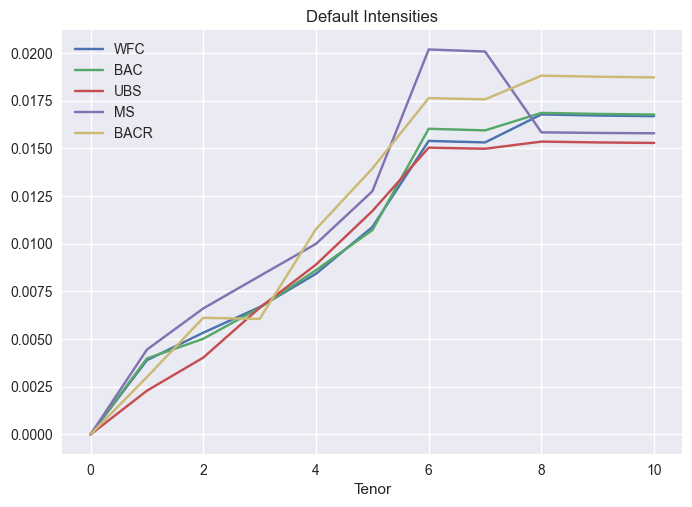

In [82]:
default_intensities.plot(title = 'Default Intensities', xlabel = 'Tenor')

# Correlation matrix

First, we are going to calculate the correlation matrix of these assets

In [83]:
BAC_df = BAC_df.drop(columns  = ['Ticker'])
WFC_df = WFC_df.drop(columns  = ['Ticker'])
UBS_df = UBS_df.drop(columns  = ['Ticker'])
MS_df = MS_df.drop(columns  = ['Ticker'])
BACR_df = BACR_df.drop(columns  = ['Ticker'])

In [84]:
Corr_input = {}
Corr_input['WFC'] = WFC_df['PX10'].pct_change().dropna()
Corr_input['BAC'] = BAC_df['PX10'].pct_change().dropna()
Corr_input['BACR'] = BACR_df['PX10'].pct_change().dropna()
Corr_input['MS'] = MS_df['PX10'].pct_change().dropna()
Corr_input['UBS'] = UBS_df['PX10'].pct_change().dropna()
Corr_input=pd.DataFrame(Corr_input).dropna()
Corr_input 

WFC       BAC      BACR        MS       UBS
Date                                                        
2017-07-03 -0.009660 -0.003092  0.023676 -0.000854 -0.021606
2017-07-04 -0.004100 -0.001917  0.039100 -0.001911  0.000439
2017-07-05  0.040880  0.005876  0.004392  0.012244  0.024709
2017-07-06  0.025978  0.006684  0.008248  0.006571  0.019773
2017-07-07 -0.012627  0.015121  0.010645 -0.001434  0.008670
...              ...       ...       ...       ...       ...
2021-09-06 -0.000778 -0.004232 -0.022976 -0.000779 -0.005002
2021-09-07  0.002642 -0.006828  0.026262 -0.007777 -0.020854
2021-09-08 -0.009226 -0.022000 -0.003054 -0.008066  0.019157
2021-09-09  0.006503  0.029650 -0.012058  0.013310 -0.003275
2021-09-10  0.005584 -0.007095 -0.021515 -0.000669 -0.017687

[1095 rows x 5 columns]

In [85]:
Corr_input.shape[0]

1095

For Kendall's Tau 
- Data has to be normal

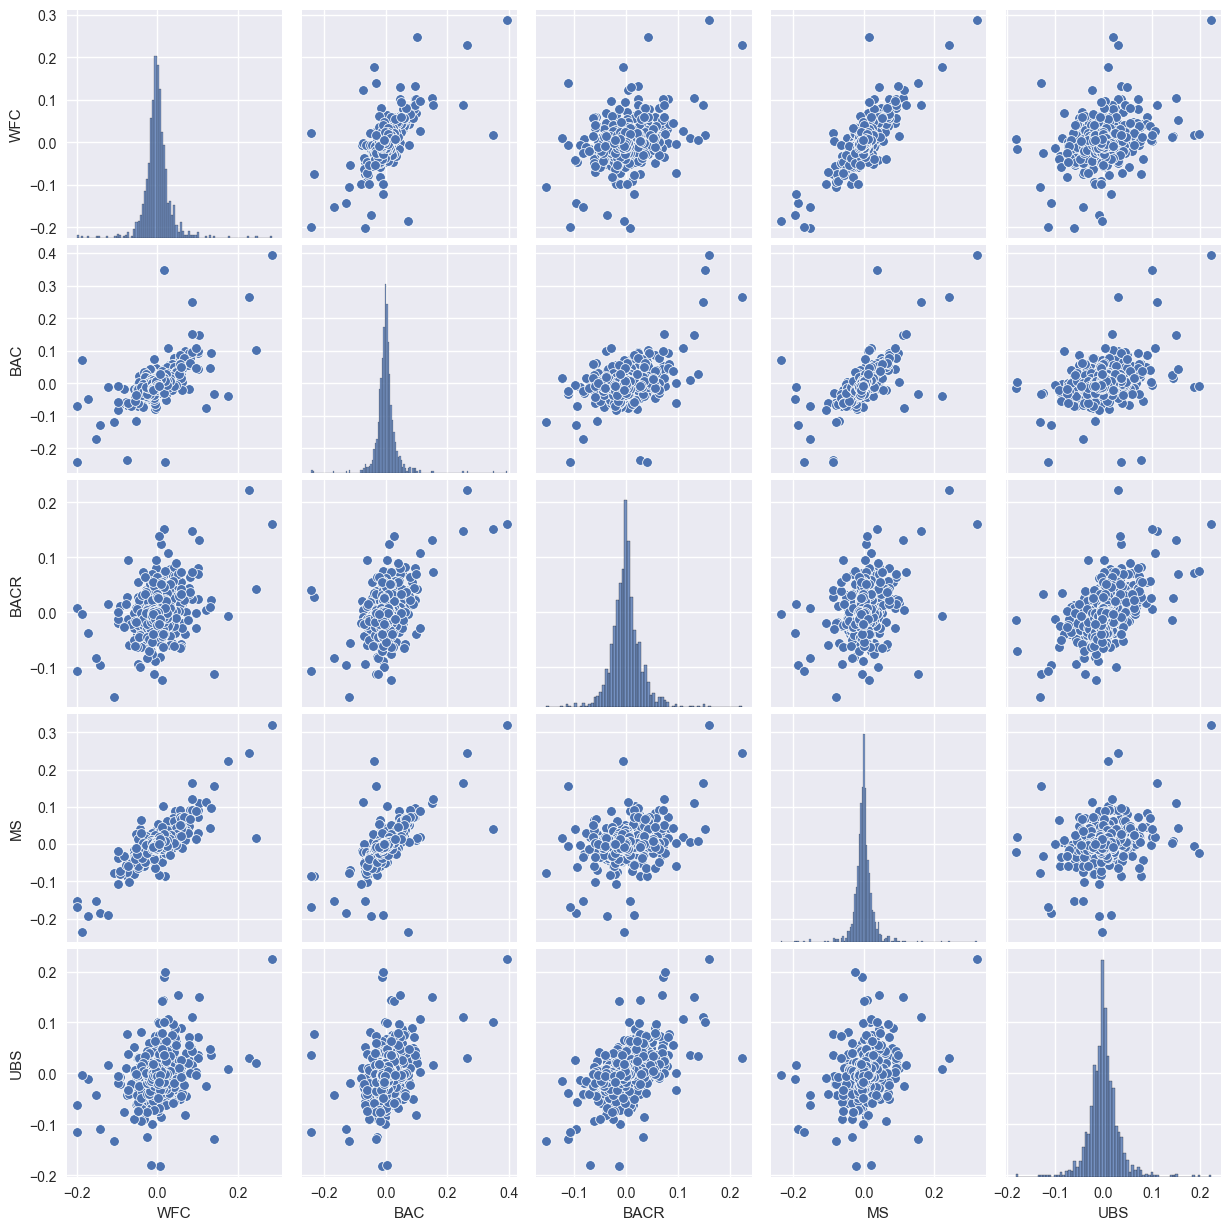

In [86]:
sns.pairplot(Corr_input)

<Axes: >

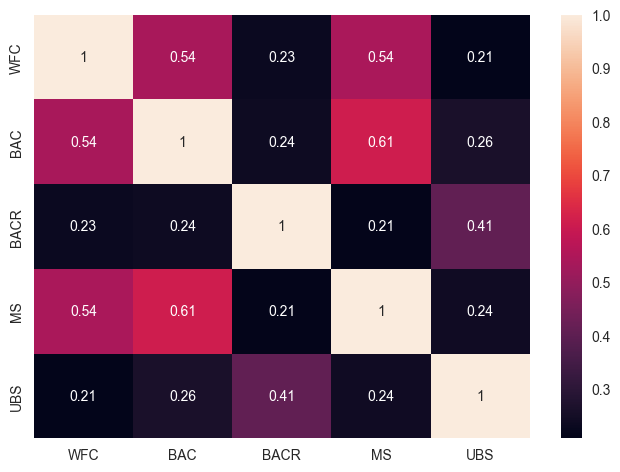

In [87]:
SIGMA_t = Corr_input.corr(method = 'kendall')
sns.heatmap(SIGMA_t, annot = True)

For Spearman's rho:
- Generate pseudo-samples by fitting an Empirical Cumulative Distribution Function to Corr_input

In [88]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz

pseudo_samples = {}
for k in Corr_input.columns:
    kde = gaussian_kde(Corr_input[k])
    x = np.linspace(min(Corr_input[k]), max(Corr_input[k]))
    kde_values = kde(x)

    cdf_values = cumtrapz(kde_values, x, initial=0)
    cdf_values /= cdf_values[-1]

    def transform_to_uniform(data, x_grid, cdf_values):
        cdf_function = interp1d(x_grid, cdf_values, kind='linear', fill_value="extrapolate")
        uniform_data = cdf_function(data)
        return uniform_data

    pseudo_samples[k] = transform_to_uniform(Corr_input[k], x, cdf_values)
pseudo_samples = pd.DataFrame(pseudo_samples)
pseudo_samples

WFC       BAC      BACR        MS       UBS
0     0.342066  0.459223  0.832993  0.494602  0.199001
1     0.438090  0.480729  0.921337  0.472898  0.515176
2     0.925704  0.617957  0.592246  0.733275  0.836819
3     0.851099  0.630160  0.656930  0.635576  0.790087
4     0.294945  0.757548  0.689935  0.482693  0.652946
...        ...       ...       ...       ...       ...
1090  0.495690  0.438356  0.174289  0.496156  0.422786
1091  0.555610  0.390829  0.850927  0.352422  0.206790
1092  0.349559  0.173110  0.460987  0.346497  0.784255
1093  0.623246  0.889492  0.311549  0.751625  0.452116
1094  0.607149  0.385942  0.190912  0.498412  0.239612

[1095 rows x 5 columns]

<Axes: >

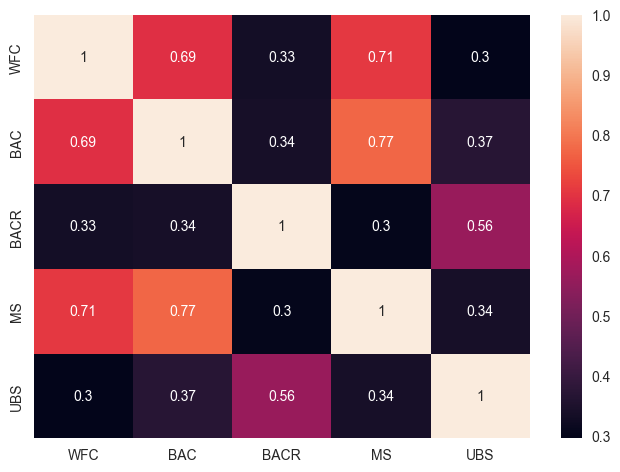

In [89]:
sns.heatmap(pseudo_samples.corr(method = 'spearman'), annot = True)

In [92]:
SIGMA_s = pseudo_samples.corr(method = 'spearman')

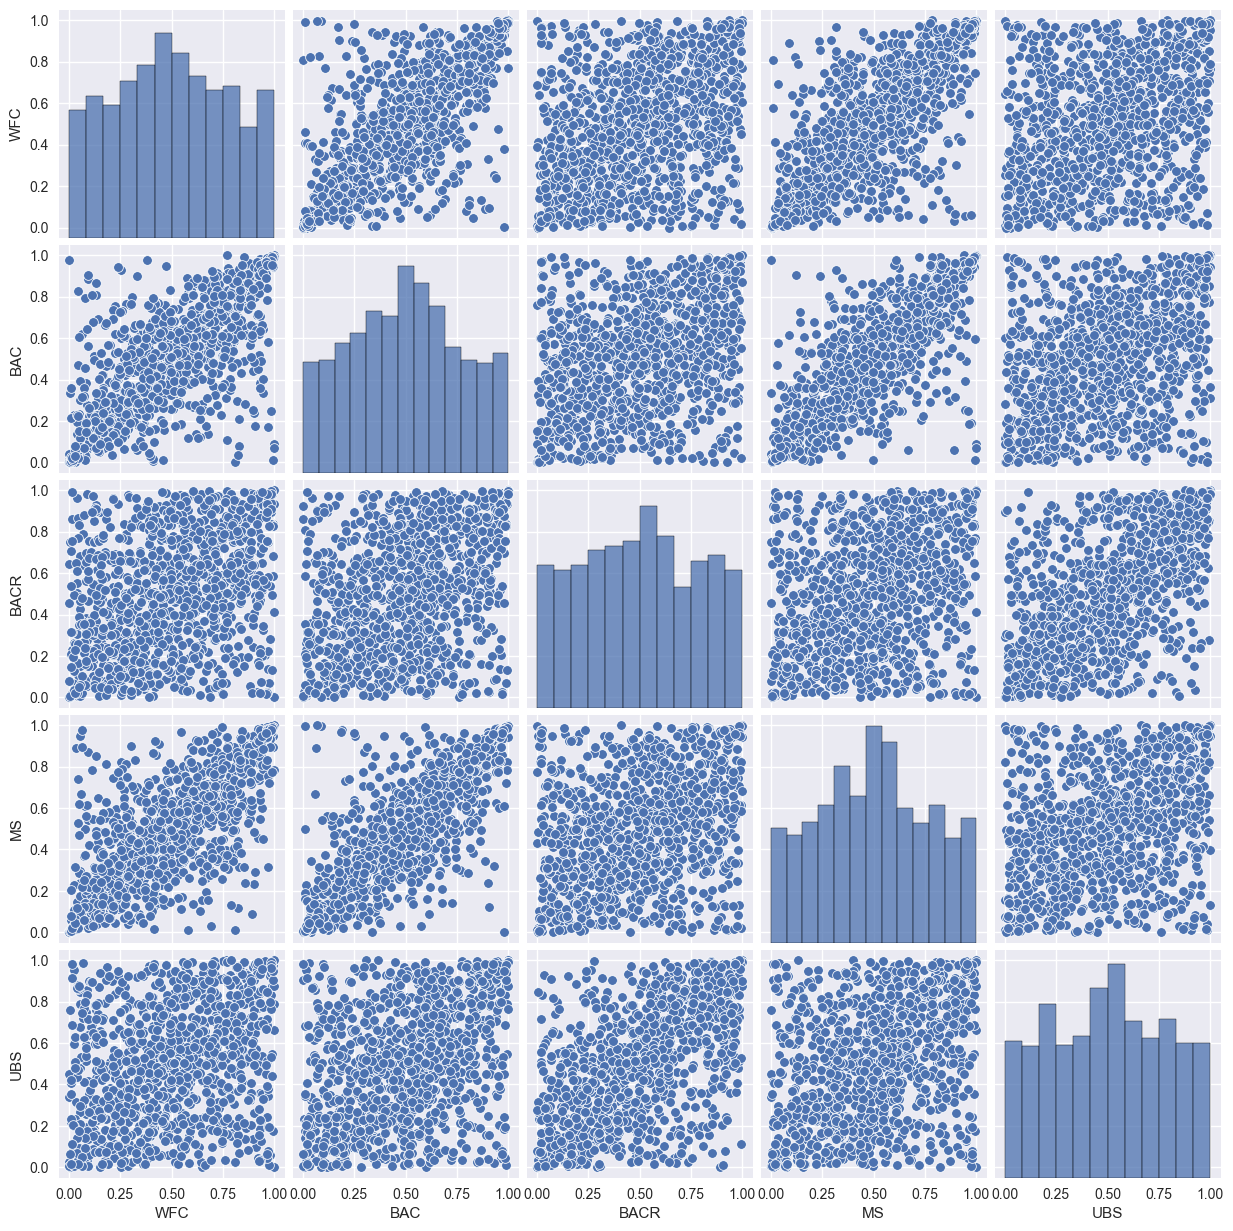

In [90]:
sns.pairplot(pseudo_samples)

In [93]:
L_s = np.linalg.cholesky(SIGMA_s)
L_s

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.69367408, 0.72028902, 0.        , 0.        , 0.        ],
       [0.33357777, 0.14875662, 0.9309121 , 0.        , 0.        ],
       [0.70611513, 0.3933616 , 0.01063739, 0.58868915, 0.        ],
       [0.29583018, 0.22655287, 0.46270925, 0.06032689, 0.8021341 ]])

For Pearson's rho:
- Use unchanged data set

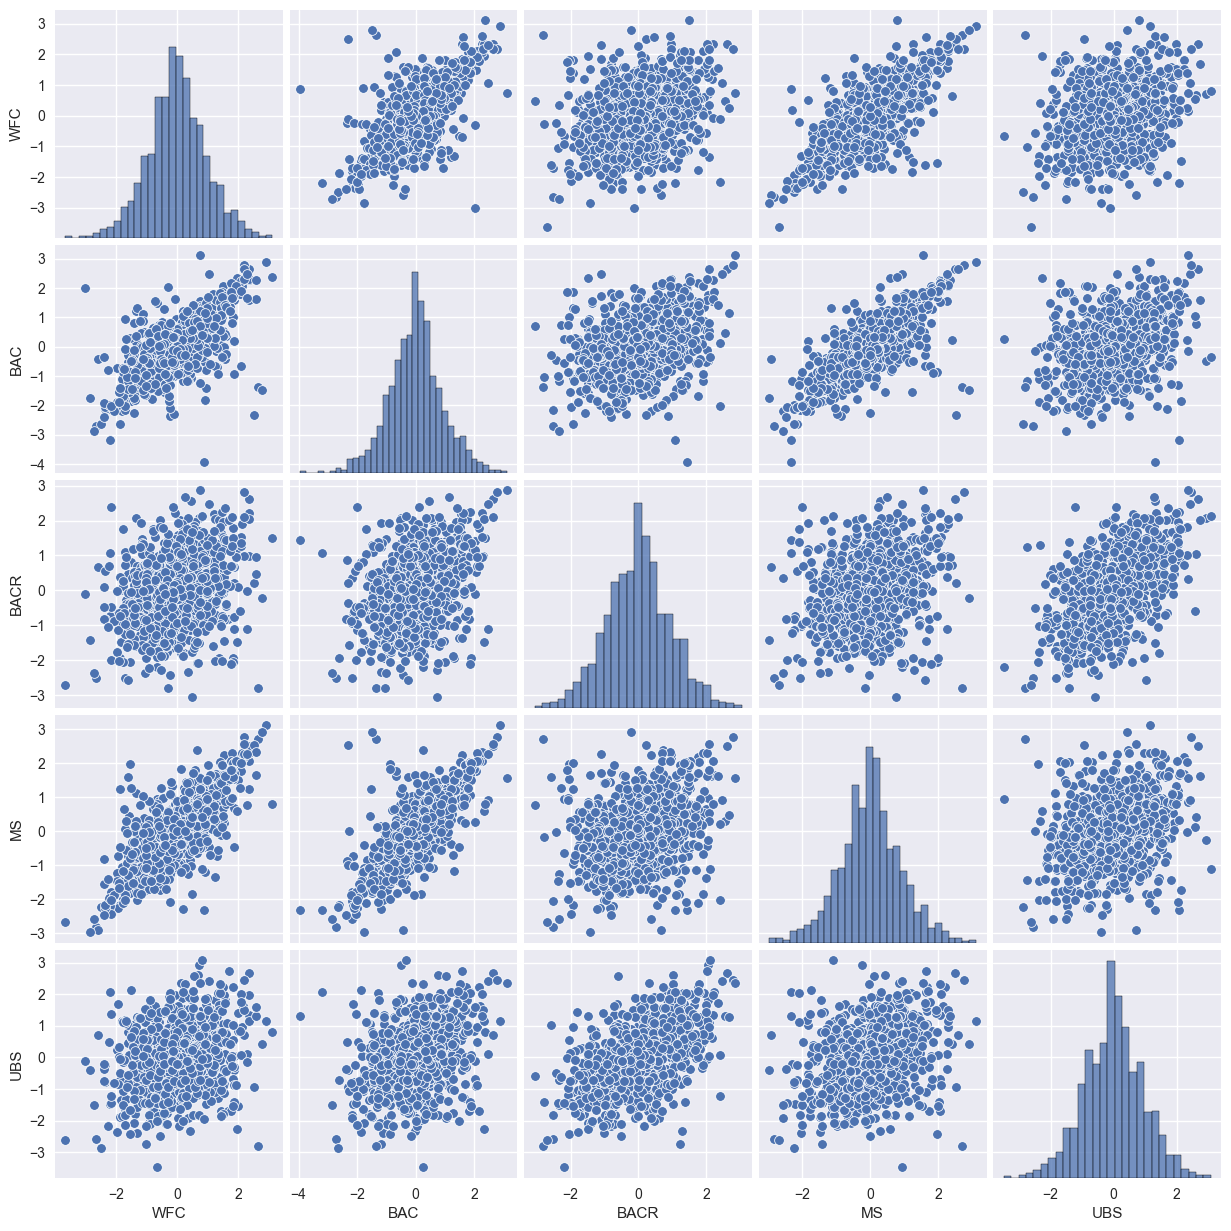

In [94]:
from scipy.stats import norm
normal_samples = {}
for k in pseudo_samples.columns:
    normal_samples[k] = norm.ppf(pseudo_samples[k])
normal_samples = pd.DataFrame(normal_samples)
sns.pairplot(normal_samples)

<Axes: >

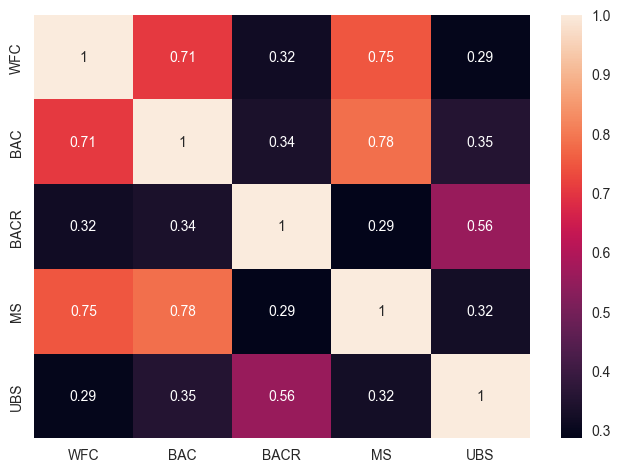

In [95]:
SIGMA_p = normal_samples.corr(method = 'pearson')
sns.heatmap(SIGMA_p, annot = True)

In [96]:
L_p = np.linalg.cholesky(SIGMA_p)
L_p

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.70571717,  0.70849367,  0.        ,  0.        ,  0.        ],
       [ 0.31879989,  0.16076157,  0.93408905,  0.        ,  0.        ],
       [ 0.7489062 ,  0.36114035, -0.01128693,  0.55550856,  0.        ],
       [ 0.29364452,  0.20823515,  0.46228432,  0.05892955,  0.80822741]])

These matrices will serva as factors for simulated random numbers to generate correlated random variables.

# Copulas

## Gaussian Copula

In [97]:
def gaussian_copula(u, SIGMA):
    """
    Gaussian copula density function:
    ---------------------------------
    u    : nx1 array: unif R.V
    SIGMA: nxn array: Correlation matrix
    """
    u = np.array(u).reshape(-1,1)
    n = u.shape[0]
    A = 1 / det(SIGMA)**0.5
    B = ((norm_inv_v(u).T).dot(inv(SIGMA) - np.eye(n))).dot(norm_inv_v(u))
    return A * np.exp(-0.5 * B)

In [98]:
gaussian_copula(pseudo_samples.iloc[0,:], SIGMA_p)

array([[0.96044181]])

## T-Student copula degrees of Freedom

## Log-likelihood

In [99]:
from scipy.stats import t

In [100]:
t.fit(Corr_input)[0]

2.358068321381987

In [101]:
from statsmodels.distributions.copula.api import StudentTCopula

In [102]:
student = StudentTCopula(corr = SIGMA_p, df = 1, k_dim = 5)
student.logpdf(np.array(Corr_input))

array([       nan,        nan, 8.72873706, ...,        nan,        nan,
              nan])

In [103]:
import numpy as np
from scipy.stats import t
from scipy.optimize import minimize

# Simuler des données
np.random.seed(42)

# Fonction de log-vraisemblance pour la copule de Student
def neg_log_likelihood(df):
    if df <= 2:
        return np.inf  # éviter des problèmes avec des degrés de liberté trop bas
    total_log_likelihood = 0
    for i in range(Corr_input.shape[1]):
        total_log_likelihood += np.sum(t.logpdf(Corr_input.iloc[:, i], df))
    return -total_log_likelihood

# Minimisation de la fonction de négative log-vraisemblance
result = minimize(neg_log_likelihood, x0=[1], bounds=[(2, None)])
estimated_df = result.x[0]

print(f'Estimated degrees of freedom: {estimated_df}')


Estimated degrees of freedom: 2.0


Degree of freedom of 2

# Basket CDS Price

In [104]:
class Basket:
    """
    Basket k'th to default
    """
    def __init__(self, SIGMA, survivals, lambdas, N):
    
        """
        Step 1: Instantiate object with 
                - SIGMA: Correlation matrix
                - Survivals: Probability of survival matrix
                - Lambdas : Hazard rate matrix
                - N : Number of iteration
        
        Step 2: call the method:  get_results()
                param: copula: Sampling methodology used:
                            "g": Gaussian copula
                            "t": t copula
                       nu:   : Degree of freedom
        If Gaussian method is called, nu parameter is ignored.
        ----------------------------------------------


        ----------------------------------------------
        required function:
        cholesky 
        norm_cdf_v
        t_student_cdf
        """
        ########################################################
        # Input parameter
        self.SIGMA = np.array(SIGMA)     # Correlation Matrix
        self.survivals = survivals       # Survival probability
        self.lambdas = np.array(lambdas) # hazard rate
        self.N = int(N)                  # Number or iterations
        
        ########################################################
        
        # Automated parameter
        self.n_asset = self.SIGMA.shape[0] # number of asset
                
            
        # Updatable parameter
        # Cholesky decomposition# Lower triangle
        self.S = np.empty_like(self.SIGMA) 
        
        # Mehtod to run while instantiating object
        self._set_cholesky()

        # Empty arrays
        ## Random Number array
        self.Z = np.empty((self.N, self.n_asset), dtype=float)  # 
        self.U = np.empty_like(self.Z)

        ## Time to default
        self.exact_time_to_default = np.zeros((self.n_asset,0))
        self.year_to_default = np.zeros((self.n_asset,0))

        
        
        # Spreads 
        self.spreads = np.array([])
        
        ######################################################

#         self.start_time = 0                 # Used to keep track of time taken for the function to execute.
#         self.runtime = 0                    # Total time taken.
#         self.df = pd.DataFrame(data=None, columns=["N", "1st",
#                                                    "2nd","3rd",
#                                                    "4th", "5th", 
#                                                   "time"])
    


    
    
    
    
    def get_results(self, copula = "t", nu = 8, RR=0.4):
        """
        Use this method to calculate the spread directly. 
        -------------------------------------------------
                copula: methodology
                string 'g': Gaussian
                       't': t-student
        nu    : int: degree of freedom
        -------------------------------------------------
        Needs to explicitly call RR = 0.4 in the method
        """
        start_time = time.time()
        self._set_copula(copula, nu) # sampling
        self._set_time_to_default()
        self._set_payment_legs(RR)
        
        runtime = (time.time() - start_time)
        return self.N, runtime, self.spreads
    
    

    def _set_copula(self, copula= "t", nu = 7):
        """
        copula: methodology
                string 'g': Gaussian
                       't': t-student
        nu    : int: degree of freedom
        --------------------------------------
        requires: norm_cdf_v
                  t_student_cdf
                  
        --------------------------------------
        nb: fix seed to compare methodologie / params
        """

        #generate N x n_asset random standard Normal variable 
        self.Z = np.random.normal(0, 1, (self.N,self.n_asset))
        
    
        if copula =="g":
            
            # Apply norm CDF to each element of the array 
            #------------------------------
            # NB: I am using numpy.vectorize which is not 
            # the most efficient method but it avoids us
            # using an explicit loop. The alternative was
            # to use the built-in function from scipy 
            #(i.e. import scipy.stats)
            X = self.S.dot(self.Z.T).T
            U = norm_cdf_v(X)
            
        elif copula =="t":
            #  self.copula =="t"
            # Generate a 3D np.array: (N x nu x n Z-R.N)
            # square the input and sum on the 1-axis
            # i.e. if nu = 7, it will add 7 square - r.n
            s = np.sum(np.random.normal(0,1,(self.N,nu, self.n_asset))**2, axis = 1)
            s = np.sqrt(s/nu)
            Y = self.Z/s
            X = self.S.dot(Y.T).T
            U = t_student_cdf(X, nu).reshape(self.N, self.n_asset)
        
        else:
            print("copula method undefined.")
        
        self.U = U
    
    
    def _set_cholesky(self):
        """
        Cholesky decomposition of correlation matrix
        """
        self.S = np.linalg.cholesky(self.SIGMA)

        
    def _set_time_to_default(self):
        ttd = np.zeros((self.n_asset, 0)) # time to default
        ytd = np.zeros((self.n_asset, 0)) # year to default
        for i in range(self.N):
            temp = self._get_time_to_default(self.lambdas,
                                        self.survivals, 
                                        self.U[i:i+1,:][0])
            ttd = np.append(ttd, temp[0])
            ytd = np.append(ytd, temp[1])
            
        
        
        self.exact_time_to_default = ttd.reshape(self.N, self.n_asset)
        self.year_to_default = ytd.reshape(self.N, self.n_asset)
        

                
    
    
    def _set_payment_legs(self, RR= 0.4):
        premium_leg = np.zeros(self.n_asset, dtype = float)
        default_leg = np.zeros(self.n_asset, dtype = float)
        
        for i in range(self.N):
            
            pl_, dl_ = self._legs_payments(self.exact_time_to_default[i],
                                     self.year_to_default[i],
                                     self.n_asset, RR)
            
            
            premium_leg += pl_
            default_leg += dl_
    
        spreads = np.array(default_leg)/np.array(premium_leg)
        
        self.spreads = spreads
        
        return spreads
    
    
    @staticmethod
    def _legs_payments(default_time,default_year,n_asset, RR = 0.4):
        """
        Legs cash flow:
        ------------------
        input: 
        default_time: 5x1 array 
        default_year: 5x 1 array
        -------------------
        output: 
            Premium leg
            Default leg
        """
        
        
        mat= default_time.shape[0]
        

        # ignore if default time < 0.25 (quaterly)
        for i in range(len(default_time)):
            if default_time[i] <= 0.25: # quaterly
                default_time[i]=9999

        def_order=np.argsort(default_time) #gives index
        
        #number of default
        n_defaults=len(default_year)-np.count_nonzero(default_year== 999)

        
        # array for default / premium leg
        premium_leg=np.zeros(n_asset,dtype= float) # premium leg
        default_leg=np.zeros(n_asset,dtype= float) # default leg



        if n_defaults ==0:
            for k in range(len(premium_leg)):
                premium_leg[k]=zcb(mat)*mat
                default_leg[k]=0
        else:
            premium_leg_1=0
            tau_1=0
            loss=0
            for i in range(n_defaults):

                tau=default_time[def_order[i]] # The ith default time


                default_leg[i]=zcb(tau)*(1-RR)* (1/n_asset) # Assuming equal weight
                premium_leg[i]=premium_leg_1+(1-loss)*zcb(tau)*(tau-tau_1) 
                loss+=(1/n_asset) # Assuming equal weight
                premium_leg_1=premium_leg[i]
                tau_1=tau
            if  n_defaults < n_asset:
                last_default_time=default_time[def_order[n_defaults-1]]
                non_default_premium=zcb(mat)*(mat-last_default_time)*(1-loss)
                for j in range(n_defaults,n_asset):
                    premium_leg[j]=non_default_premium+premium_leg[n_defaults-1]
                    default_leg[j]=0



        return premium_leg,default_leg



    @staticmethod
    def _get_time_to_default(lambdas,survivals,u):

        """
        1D version (simple)
        """

        
        T = 999 # if cds doesn't default within contract life (i.e. 5y)
                # set an arbitrary large number (trick taken from A. Sehra paper)
    
        default_year=[] #
        dt=[]

        
        for i in range(lambdas.shape[0]):
            flag=0
            
            
            for j in range(lambdas.shape[0]):

                if np.abs(np.log(1-u[i])) < np.sum(lambdas[i,0:j+1]):
                    default_year.append(j)
                    flag=1
                    break
                    
            if flag==0:
                default_year.append(T)

        for i in range(len(default_year)):
            if default_year[i] == T:
                dt.append(T)
            
            else:
                dt.append((-1/lambdas[i][default_year[i]])*np.log((1-u[i])/(survivals[i][default_year[i]])))        

        default_time=np.array(default_year)+np.array(dt)


        return default_time,default_year

In [105]:
mats = []
lambdas = []
survivals = []
for i in surv_lbd:
    mats.append(surv_lbd[i][0][:11])
    survivals.append(surv_lbd[i][1][:11])
    lambdas.append(surv_lbd[i][2][:11])
mats = np.array(mats, dtype = float)
survivals = np.array(survivals, dtype = float)
lambdas = np.array(lambdas, dtype = float)

## Nth to default CDS price 

In [106]:
a = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],10000)
a.get_results(copula="t", nu = 2, RR = 0.4)[2][0] * 10000

11.081443153530065

In [107]:
start_time = time.time()

temp = Basket(SIGMA_t, survivals[:,1:],lambdas[:,1:],10000)
temp._set_copula("t", 8)
temp._set_time_to_default()
temp._set_payment_legs()*10000

print("--- %s seconds ---" % (time.time() - start_time))

--- 11.031297206878662 seconds ---


# Difference in Nth to default spreads between copula and correlation measure

In [108]:
np.random.seed(0)

In [109]:
# Comparison between copula method and correlation measure

Res = {}

# Pearson correlation
pearson = Basket(SIGMA_p, survivals[:,1:],lambdas[:,1:],10000)
pears = pearson.get_results(copula="g", nu = 2, RR = 0.4)
Res['Pearson'] = pears[2] * 10000

# Kendall correlation
kendall = Basket(SIGMA_t, survivals[:,1:],lambdas[:,1:],10000)
kend = kendall.get_results(copula="g", nu = 2, RR = 0.4)
Res['Kendall'] = kend[2] * 10000

# Spearman correlation
spearman = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],10000)
spear = spearman.get_results(copula="g", nu = 2, RR = 0.4)
Res['Spearman'] = spear[2] * 10000

Res = pd.DataFrame(Res)


In [110]:
Res.index = np.arange(1,6)
Res

Pearson   Kendall  Spearman
1  10.141262  6.238648  9.241758
2   2.528907  2.108070  2.666450
3   0.825672  0.666213  0.968800
4   0.232826  0.125221  0.230278
5   0.048188  0.008858  0.025875

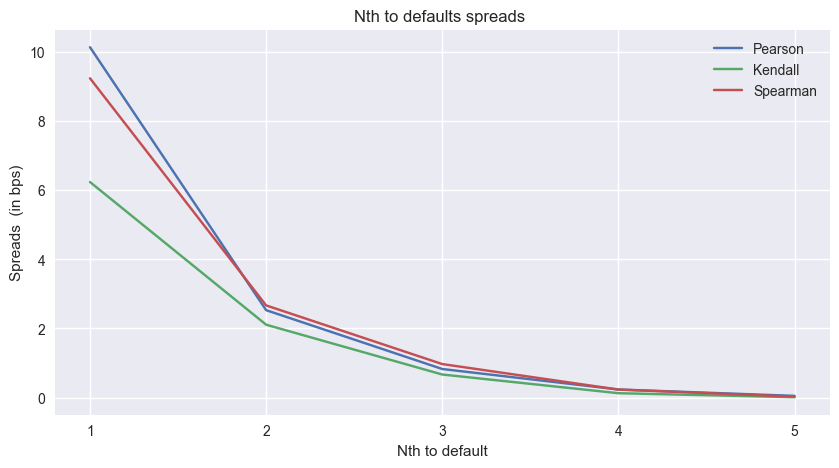

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(Res['Pearson'], label='Pearson')
plt.plot(Res['Kendall'], label='Kendall')
plt.plot(Res['Spearman'], label='Spearman')
plt.title('Nth to defaults spreads ')
plt.xlabel('Nth to default')
plt.ylabel('Spreads  (in bps)')
plt.legend()
plt.xticks(range(1,len(Res) +1))
plt.grid(True)
plt.show()

# Monte Carlo

In [ ]:
runtime_g= []
spread_g = []
simulation_g= []
sim_list = [100, 200, 500, 700, 1000, 2000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000, 30000, 50000, 70000, 80000, 90000, 100000]

for i in sim_list:
    mc = Basket(SIGMA_p, survivals[:,1:],lambdas[:,1:],i)
    df1 = mc.get_results(copula = "g", nu = 2, RR = 0.4)
    simulation_g.append(df1[0])
    runtime_g.append(df1[1])
    spread_g.append(df1[2] * 10000)

In [ ]:
spread_g = pd.DataFrame(spread_g)
spread_g.index = sim_list
spread_g.index.name = 'Number of simulations'
spread_g.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']

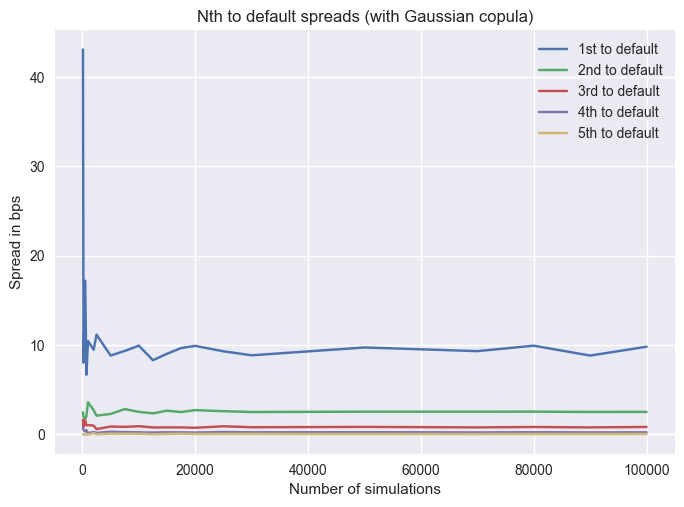

In [ ]:
spread_g.plot(title = 'Nth to default spreads (with Gaussian copula)', ylabel = 'Spread in bps');

In [ ]:
runtime_t = []
spread_t = []
simulation_t = []
sim_list = [100, 200, 500, 700, 1000, 2000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000, 30000, 50000, 70000, 80000, 90000, 100000]
for i in sim_list:
    mc = Basket(SIGMA_p, survivals[:, 1:], lambdas[:, 1:], i)
    df1 = mc.get_results(copula="t", nu = 2, RR = 0.4)
    simulation_t.append(df1[0])
    runtime_t.append(df1[1])
    spread_t.append(df1[2] * 10000)

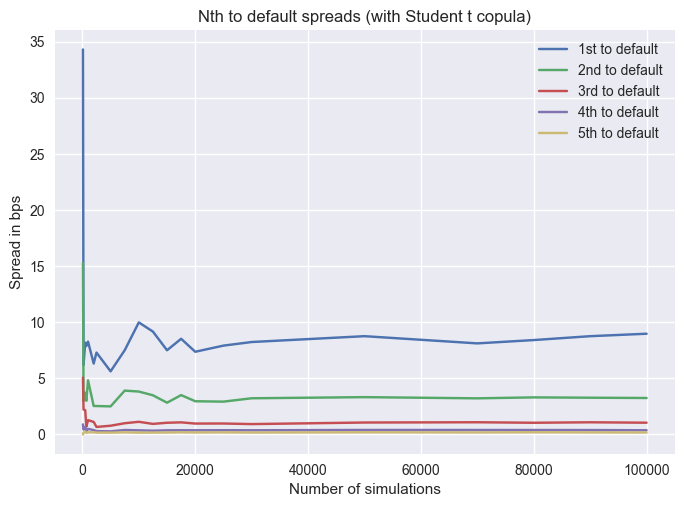

In [ ]:
spread_t = pd.DataFrame(spread_t)
spread_t.index = sim_list
spread_t.index.name = 'Number of simulations'
spread_t.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_t.plot(title = 'Nth to default spreads (with Student t copula)', ylabel = 'Spread in bps');

In [ ]:
runtime_t = []
spread_s = []
simulation_t = []
sim_list = [100, 200, 500, 700, 1000, 2000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000, 30000, 50000, 70000, 80000, 90000, 100000]
for i in sim_list:
    mc = Basket(SIGMA_s, survivals[:, 1:], lambdas[:, 1:], i)
    df1 = mc.get_results(copula="t", nu = 2, RR = 0.4)
    simulation_t.append(df1[0])
    runtime_t.append(df1[1])
    spread_s.append(df1[2] * 10000)

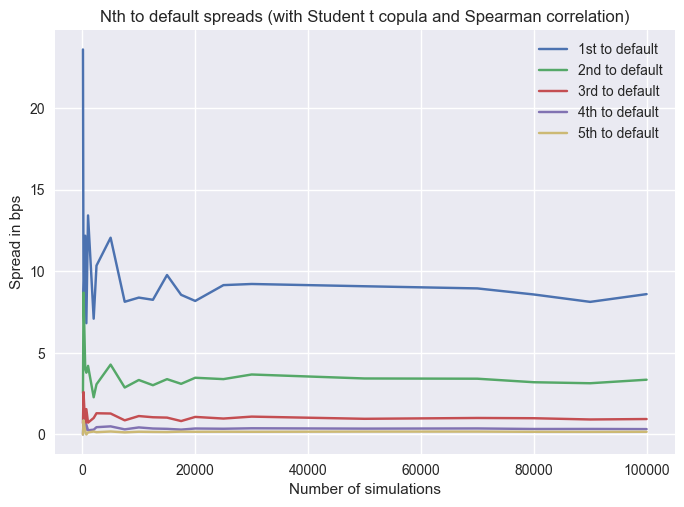

In [ ]:
spread_s = pd.DataFrame(spread_s)
spread_s.index = sim_list
spread_s.index.name = 'Number of simulations'
spread_s.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_s.plot(title = 'Nth to default spreads (with Student t copula and Spearman correlation)', ylabel = 'Spread in bps');

### 1st to default swaps

<Axes: title={'center': '1st to default swaps spreads'}, xlabel='Number of simulations', ylabel='Spread in bps'>

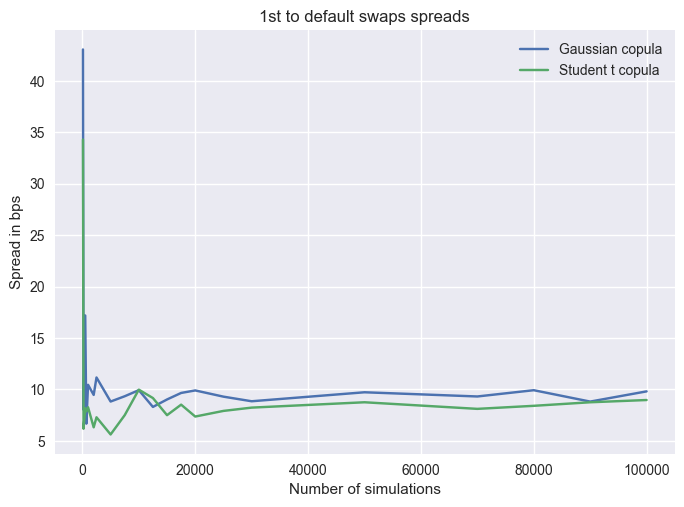

In [ ]:
first = [spread_g['1st to default'], spread_t['1st to default']]
first = pd.DataFrame(first).T
first.columns = ['Gaussian copula', 'Student t copula']
first.plot(title = '1st to default swaps spreads', ylabel = 'Spread in bps', )

In [ ]:
one = np.mean((spread_g['1st to default'] - spread_t['1st to default'])**2)

In [ ]:
first.mean(), first.std()

(Gaussian copula                            10.897683
 Student t copula (Kendall correlation)      9.576599
 Student t copula (Spearman Correlation)     9.809570
 dtype: float64,
 Gaussian copula                            5.110934
 Student t copula (Kendall correlation)     1.983935
 Student t copula (Spearman Correlation)    3.569527
 dtype: float64)

### 2nd to default swaps

<Axes: title={'center': '2nd to default swaps spreads'}, xlabel='Number of simulations', ylabel='Spread in bps'>

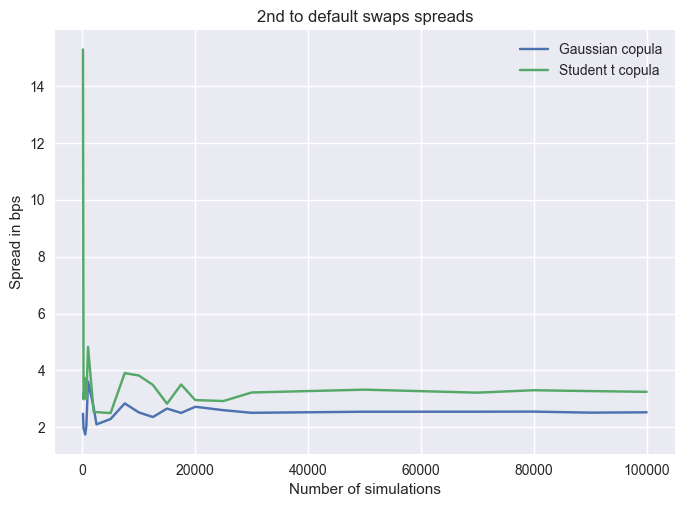

In [ ]:
second = [spread_g['2nd to default'], spread_t['2nd to default']]
second = pd.DataFrame(second).T
second.columns = ['Gaussian copula', 'Student t copula']
second.plot(title = '2nd to default swaps spreads', ylabel = 'Spread in bps', )

In [ ]:
two = np.mean((spread_g['2nd to default'] - spread_t['2nd to default'])**2)

In [ ]:
second.mean(), second.std()

(Gaussian copula                            2.658891
 Student t copula (Kendall correlation)     2.761062
 Student t copula (Spearman Correlation)    3.604979
 dtype: float64,
 Gaussian copula                            0.612771
 Student t copula (Kendall correlation)     0.307992
 Student t copula (Spearman Correlation)    1.263696
 dtype: float64)

### 3rd to default swaps

<Axes: title={'center': '3rd to default swaps spreads'}, xlabel='Number of simulations', ylabel='Spread in bps'>

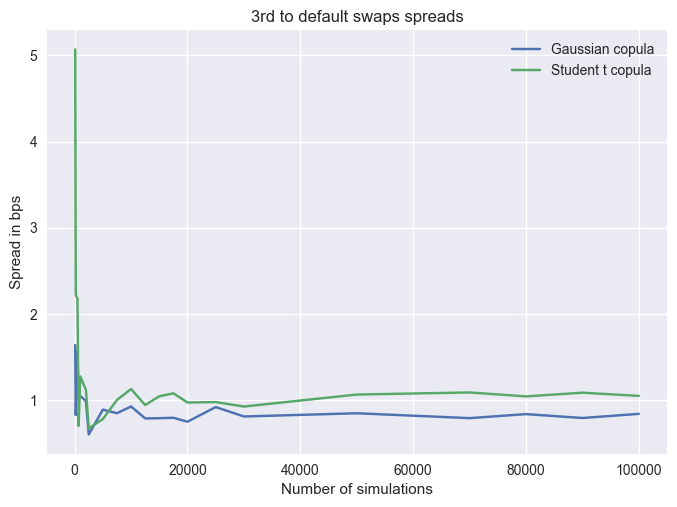

In [ ]:
third = [spread_g['3rd to default'], spread_t['3rd to default']]
third = pd.DataFrame(third).T
third.columns = ['Gaussian copula', 'Student t copula']
third.plot(title = '3rd to default swaps spreads', ylabel = 'Spread in bps' )

In [ ]:
three = np.mean((spread_g['3rd to default'] - spread_t['3rd to default'])**2)

In [ ]:
third.mean(), third.std()

(Gaussian copula                            0.792459
 Student t copula (Kendall correlation)     0.880326
 Student t copula (Spearman Correlation)    1.070749
 dtype: float64,
 Gaussian copula                            0.209880
 Student t copula (Kendall correlation)     0.332562
 Student t copula (Spearman Correlation)    0.419522
 dtype: float64)

### 4th to default swaps

<Axes: title={'center': '4th to default swaps spreads'}, xlabel='Number of simulations', ylabel='Spread in bps'>

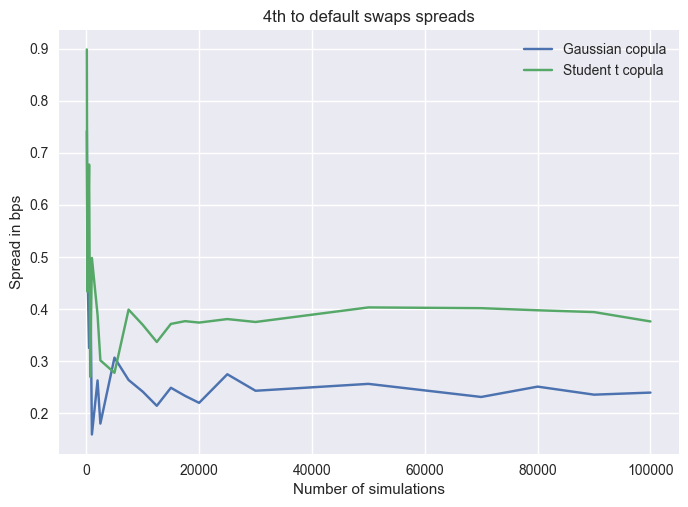

In [ ]:
fourth = [spread_g['4th to default'], spread_t['4th to default']]
fourth = pd.DataFrame(fourth).T
fourth.columns = ['Gaussian copula', 'Student t copula']
fourth.plot(title = '4th to default swaps spreads', ylabel = 'Spread in bps', )

In [ ]:
four = np.mean((spread_g['4th to default'] - spread_t['4th to default'])**2)

In [ ]:
fourth.mean(), fourth.std()

(Gaussian copula                            0.177722
 Student t copula (Kendall correlation)     0.221787
 Student t copula (Spearman Correlation)    0.370216
 dtype: float64,
 Gaussian copula                            0.090740
 Student t copula (Kendall correlation)     0.084972
 Student t copula (Spearman Correlation)    0.160048
 dtype: float64)

### 5th to default swaps

<Axes: title={'center': '5th to default swaps spreads'}, xlabel='Number of simulations', ylabel='Spread in bps'>

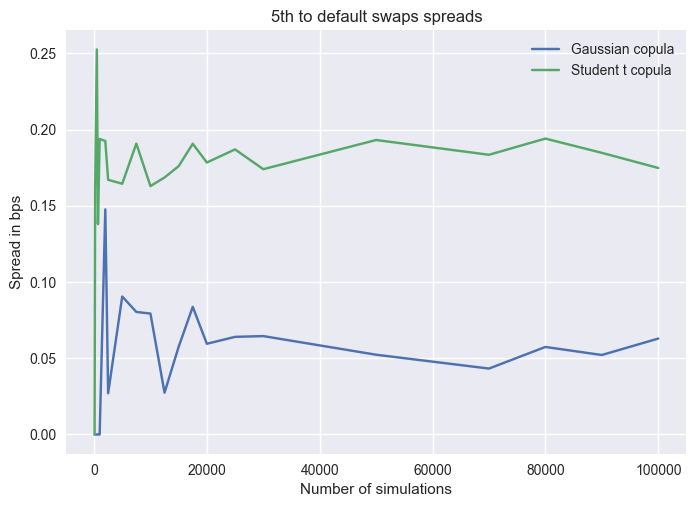

In [ ]:
fifth = [spread_g['5th to default'], spread_t['5th to default']]
fifth = pd.DataFrame(fifth).T
fifth.columns = ['Gaussian copula', 'Student t copula']
fifth.plot(title = '5th to default swaps spreads', ylabel = 'Spread in bps', )

In [ ]:
five = np.mean((spread_g['5th to default'] - spread_t['5th to default'])**2)

In [ ]:
fifth.mean(), fifth.std()

(Gaussian copula                            0.037964
 Student t copula (Kendall correlation)     0.092288
 Student t copula (Spearman Correlation)    0.181918
 dtype: float64,
 Gaussian copula                            0.023305
 Student t copula (Kendall correlation)     0.035174
 Student t copula (Spearman Correlation)    0.164935
 dtype: float64)

In [ ]:
pd.DataFrame([one, two, three, four, five], columns = ['MSE'], index = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default'])

MSE
1st to default  10.699923
2nd to default   8.572907
3rd to default   0.707834
4th to default   0.028418
5th to default   0.017507

## Recovery Rates impact (100 000 simulations)

In [ ]:
RecRate = np.arange(0,0.90, 0.1)

In [ ]:
runtime_g= []
spread_g = []
simulation_g= []


for i in RecRate:
    mc = Basket(SIGMA_p, survivals[:,1:],lambdas[:,1:],50000)
    df1 = mc.get_results(copula = "g", nu = 2, RR = i)
    simulation_g.append(df1[0])
    runtime_g.append(df1[1])
    spread_g.append(df1[2] * 10000) 

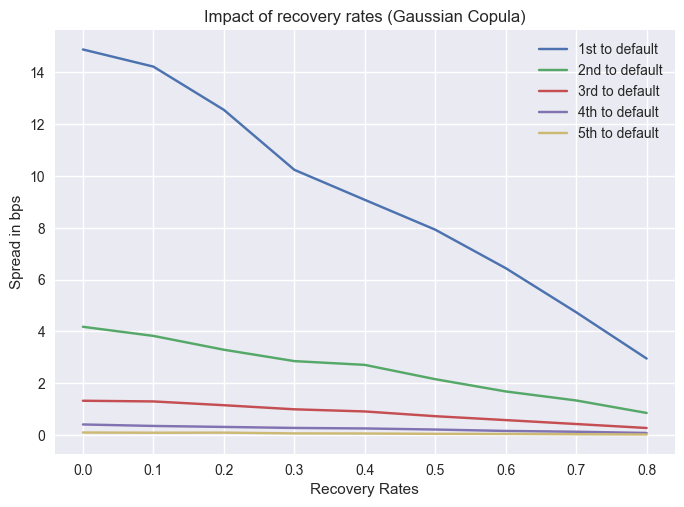

In [ ]:
spread_g = pd.DataFrame(spread_g)
spread_g.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_g.index = RecRate
spread_g.index.name = 'Recovery Rates'
spread_g.plot(title = 'Impact of recovery rates (Gaussian Copula)', ylabel = 'Spread in bps');

In [ ]:
abc = spread_g.loc[spread_g.index == 0.4]

In [ ]:
abc.iloc[0,:]

1st to default    9.081960
2nd to default    2.707994
3rd to default    0.908976
4th to default    0.252740
5th to default    0.057411
Name: 0.4, dtype: float64

In [ ]:
i, j = spread_g.shape
Mat = np.ones(spread_g.shape)
for k in range(i):
    a = spread_g.iloc[k,:]
    a-= abc.iloc[0,:]
    Mat[k] = a
M = pd.DataFrame(Mat)
M

0         1         2         3         4
0  23.970673  6.886539  2.231517  0.659442  0.153839
1  14.226334  3.826359  1.295887  0.349216  0.087646
2  12.556478  3.292906  1.149830  0.311261  0.091377
3  10.241221  2.853168  0.992044  0.272101  0.061694
4   9.081960  2.707994  0.908976  0.252740  0.057411
5   7.929658  2.155336  0.726157  0.210917  0.044355
6   6.443372  1.682015  0.575444  0.156763  0.040341
7   4.741114  1.333819  0.423971  0.125678  0.027859
8   2.952577  0.851343  0.270072  0.078334  0.020076

In [ ]:
runtime_t= []
spread_t = []
simulation_t= []


for i in RecRate:
    mc = Basket(SIGMA_t, survivals[:,1:],lambdas[:,1:],50000)
    df1 = mc.get_results(copula = "t", nu = 2, RR = i)
    simulation_t.append(df1[0])
    runtime_t.append(df1[1])
    spread_t.append(df1[2] * 10000)

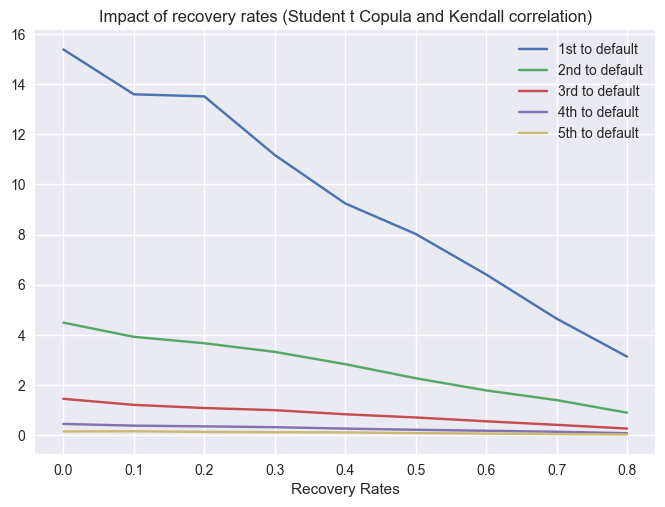

In [ ]:
spread_t = pd.DataFrame(spread_t)
spread_t.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_t.index = RecRate
spread_t.index.name = 'Recovery Rates'
spread_t.plot(title = 'Impact of recovery rates (Student t Copula and Kendall correlation)');

In [ ]:
runtime_s= []
spread_s = []
simulation_s= []


for i in RecRate:
    mc = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],50000)
    df1 = mc.get_results(copula = "t", nu = 2, RR = i)
    simulation_s.append(df1[0])
    runtime_s.append(df1[1])
    spread_s.append(df1[2] * 10000) 

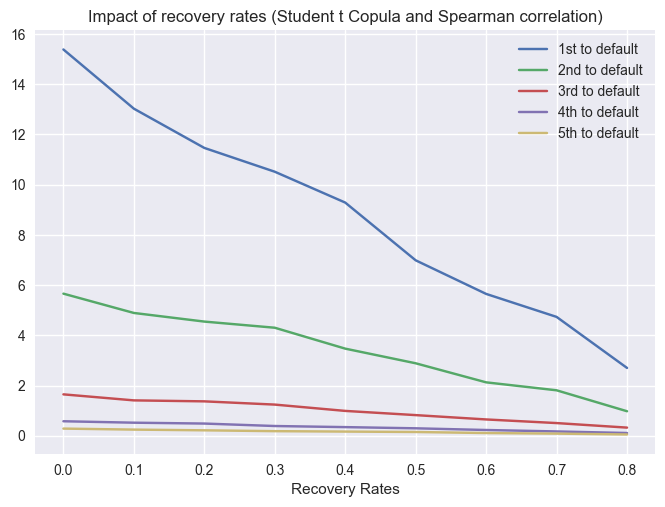

In [ ]:
spread_s = pd.DataFrame(spread_s)
spread_s.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_s.index = RecRate
spread_s.index.name = 'Recovery Rates'
spread_s.plot(title = 'Impact of recovery rates (Student t Copula and Spearman correlation)');

# Impact of Correlation Matrix shift

In [ ]:
SIGMA_t.iloc[0][0]

1.0

In [ ]:
def correl_modif(u, SIGMA):
    i,j = SIGMA.shape
    Mat = np.ones(SIGMA.shape)
    for k in range(i):
        for l in range(j):
            if k!=l:
                a = SIGMA.iloc[k][l]
                a*= u
                if a>= 1:
                    a = 1
                Mat[k][l] = a
            else:
                pass
    return pd.DataFrame(Mat)


In [ ]:
SIGMA_p

WFC       BAC      BACR        MS       UBS
WFC   1.000000  0.538658  0.231927  0.540177  0.208021
BAC   0.538658  1.000000  0.236067  0.612615  0.261820
BACR  0.231927  0.236067  1.000000  0.213251  0.406331
MS    0.540177  0.612615  0.213251  1.000000  0.239211
UBS   0.208021  0.261820  0.406331  0.239211  1.000000

In [ ]:
correl_modif(0.3, SIGMA_p)

0         1         2         3         4
0  1.000000  0.211715  0.095640  0.224672  0.088093
1  0.211715  1.000000  0.101664  0.235314  0.106429
2  0.095640  0.101664  1.000000  0.085880  0.167671
3  0.224672  0.235314  0.085880  1.000000  0.096790
4  0.088093  0.106429  0.167671  0.096790  1.000000

In [ ]:
correl_delta = np.arange(0.3, 1.7, 0.05)

In [ ]:
runtime_p= []
spread_p = []
simulation_p= []


for i in correl_delta:
    try:
        mc = Basket(correl_modif(i, SIGMA_p), survivals[:,1:],lambdas[:,1:],50000)
        df1 = mc.get_results(copula = "g", nu = 2, RR = 0.4)
        simulation_p.append(df1[0])
        runtime_p.append(df1[1])
        spread_p.append(df1[2] * 10000) 
    except:
        spread_p.append([np.nan for m in range(5)])

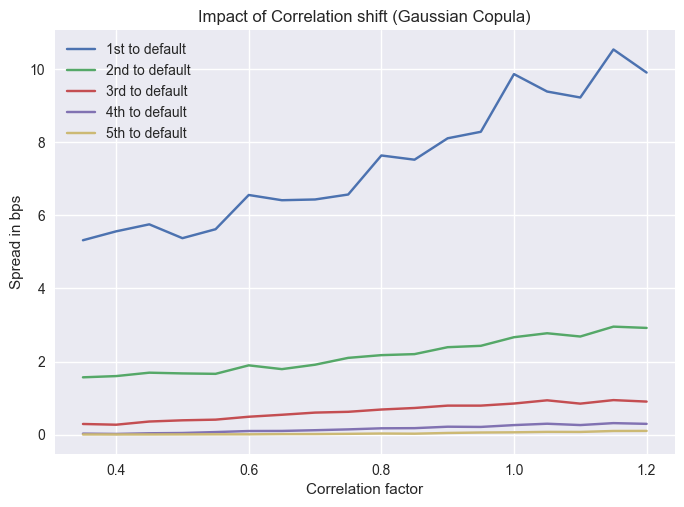

In [ ]:
spread_p = pd.DataFrame(spread_p)
spread_p.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_p.index = correl_delta
spread_p.index.name = 'Correlation factor'
spread_p = spread_p.dropna()
spread_p.plot(title = 'Impact of Correlation shift (Gaussian Copula)', ylabel = 'Spread in bps');

# Impact of Correlation method

In [ ]:
# Pearson correlation

runtime_g= []
spread_g = []
simulation_g= []



mc = Basket(SIGMA_p, survivals[:,1:],lambdas[:,1:],100000)
df1 = mc.get_results(copula = "g", nu = 2, RR = 0.4)
simulation_g.append(df1[0])
runtime_g.append(df1[1])
spread_g.append(df1[2] * 10000)

In [ ]:
spread_g = pd.DataFrame(spread_g)
spread_g.index.name = ''
spread_g.index = ['Spread']
spread_g.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_g = spread_g.T

In [ ]:
# Kendall correlation
runtime_k= []
spread_k = []
simulation_k= []



mc = Basket(SIGMA_t, survivals[:,1:],lambdas[:,1:],100000)
df1 = mc.get_results(copula = "g", nu = 2, RR = 0.4)
simulation_k.append(df1[0])
runtime_k.append(df1[1])
spread_k.append(df1[2] * 10000) 

In [ ]:
spread_k = pd.DataFrame(spread_k)
spread_k.index.name = ''
spread_k.index = ['Spread']
spread_k.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_k = spread_k.T

In [ ]:
# Spearman correlation
runtime_s= []
spread_s = []
simulation_s= []



mc = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],100000)
df1 = mc.get_results(copula = "g", nu = 2, RR = 0.4)
simulation_s.append(df1[0])
runtime_s.append(df1[1])
spread_s.append(df1[2] * 10000) 

In [ ]:
spread_s = pd.DataFrame(spread_s)
spread_s.index.name = ''
spread_s.index = ['Spread']
spread_s.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_s = spread_s.T

<Axes: >

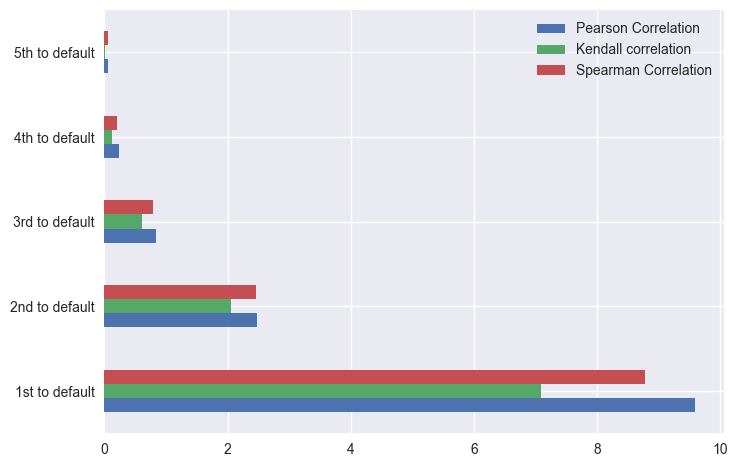

In [ ]:
first = [spread_g['Spread'], spread_k['Spread'], spread_s['Spread']]
first = pd.DataFrame(first).T
first.columns = ['Pearson Correlation', 'Kendall correlation', 'Spearman Correlation']
#first.plot(title = '1st to default swaps spreads', ylabel = 'Spread in bps', )
first.plot.barh()

# Impact of entity CDS spreads changes

In [ ]:
cds_spread 

0        1        2        3        4        5        6        7  \
Company                                                                       
WFC      0.0  23.4124  27.7391  31.8399  36.4562  42.0503   50.041  55.6287   
BAC      0.0  23.9441  27.0477  31.2963  36.3222  41.7542  50.3954  56.4366   
UBS      0.0  13.7758  18.9824  25.8932  32.6657   39.958  47.9372  53.5364   
MS       0.0  26.7402  33.2323  38.7523  43.9878  50.2984  61.5069  69.3312   
BACR     0.0  18.0754  27.4005  30.3782  38.7944  47.4815  56.7196  63.1979   

               8        9       10  
Company                             
WFC      60.8002  64.7608  67.8888  
BAC       61.568  65.4994  68.6051  
UBS       57.971  61.3738  64.0641  
MS       72.2901   74.563  76.3624  
BACR     68.8727  73.2224   76.658

In [ ]:
def cds_modif(u, cds):
    i,j = cds.shape
    Mat = np.ones(cds.shape)
    for k in range(i):
        for l in range(j):
            if l!=0:
                a = cds.iloc[k][l]
                a*= u
                Mat[k][l] = a
            else:
                Mat[k][l] = 0
    return pd.DataFrame(Mat)

In [ ]:
cds_modif(1, cds_spread)

0        1        2        3        4        5        6        7   \
0  0.0  23.4124  27.7391  31.8399  36.4562  42.0503  50.0410  55.6287   
1  0.0  23.9441  27.0477  31.2963  36.3222  41.7542  50.3954  56.4366   
2  0.0  13.7758  18.9824  25.8932  32.6657  39.9580  47.9372  53.5364   
3  0.0  26.7402  33.2323  38.7523  43.9878  50.2984  61.5069  69.3312   
4  0.0  18.0754  27.4005  30.3782  38.7944  47.4815  56.7196  63.1979   

        8        9        10  
0  60.8002  64.7608  67.8888  
1  61.5680  65.4994  68.6051  
2  57.9710  61.3738  64.0641  
3  72.2901  74.5630  76.3624  
4  68.8727  73.2224  76.6580

In [ ]:
surv_lbd= {}
for name in cds_modif(1, cds_spread).index:
    surv = []
    lbd = []
    cds = cds_modif(1, cds_spread).loc[name,:]
    surv, lbd = survival_probability(Tenors, cds, DF, 0.4)
    surv_lbd[name] = np.array([Tenors, surv, lbd])

In [ ]:
survival_probs = {}
for name in cds_spread.index:
    survival_probs[name] = surv_lbd[name][1]
survival_probs = pd.DataFrame(survival_probs)

0         1         2         3         4         5         6   \
WFC   1.0  0.996113  0.990811  0.984216  0.975956  0.965398  0.950652   
BAC   1.0  0.996025  0.991040  0.984483  0.976037  0.965635  0.950280   
UBS   1.0  0.997709  0.993696  0.987118  0.978365  0.966970  0.952536   
MS    1.0  0.995563  0.989004  0.980823  0.971067  0.958764  0.939602   
BACR  1.0  0.996996  0.990916  0.984932  0.974381  0.960889  0.944089   

            7         8         9         10  
WFC   0.936205  0.920625  0.905356  0.890370  
BAC   0.935247  0.919609  0.904282  0.889239  
UBS   0.938371  0.924071  0.910028  0.896223  
MS    0.920924  0.906448  0.892229  0.878249  
BACR  0.927644  0.910354  0.893436  0.876864

In [ ]:
def spread_modif(u, cds_spread):
    A = cds_modif(u, cds_spread)
    surv_lbd= {}
    for name in A.index:
        surv = []
        lbd = []
        cds = A.loc[name,:]
        surv, lbd = survival_probability(Tenors, cds, DF, 0.4)
        surv_lbd[name] = np.array([Tenors, surv, lbd])
    
    mats = []
    lambdas = []
    survivals = []
    for i in surv_lbd:
        mats.append(surv_lbd[i][0][:11])
        survivals.append(surv_lbd[i][1][:11])
        lambdas.append(surv_lbd[i][2][:11])
    mats = np.array(mats, dtype = float)
    survivals = np.array(survivals, dtype = float)
    lambdas = np.array(lambdas, dtype = float)
    
    return A, survivals, lambdas

In [ ]:
Spreadchange = np.arange(0.3,1.7, 0.1)

In [ ]:
runtime_g= []
spread_g = []
simulation_g= []

for i in Spreadchange:
    B = spread_modif(i, cds_spread)
    mc = Basket(SIGMA_p, B[1][:,1:],B[2][:,1:],10000)
    df1 = mc.get_results(copula = "g", nu = 2, RR = 0.4)
    simulation_g.append(df1[0])
    runtime_g.append(df1[1])
    spread_g.append(df1[2] * 10000) 

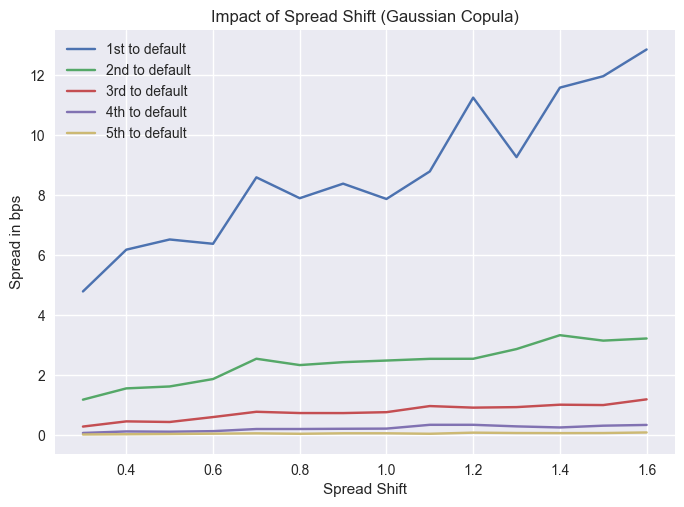

In [ ]:
spread_g = pd.DataFrame(spread_g)
spread_g.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_g.index = Spreadchange
spread_g.index.name = 'Spread Shift'
spread_g.plot(title = 'Impact of Spread Shift (Gaussian Copula)', ylabel = 'Spread in bps');

# Impact of Yield curve shift

In [ ]:
# Yield curve shift
def yc_shift(yc, u):
    return yc * u

In [ ]:
def yield_curve_shift(yc, u, cds_spread):
    curve = yc_shift(yc, u)
    DF = []
    Tenors = np.arange(1,11)
    rates = curve.iloc[0]
    for i, T in zip(rates,Tenors):
        df = 1/((1+i/100)**T)
        DF.append(df)
    DF = pd.DataFrame(DF)
    DF.index = Tenors
    DF.columns = ['DF']
    DF_data = DF.copy()
    DF_data['T'] = np.arange(1,11)
    DF_data.loc[0] = [1,0]
    DF_data = DF_data.sort_index()
    DF = DF.T
    DF.insert(0, '0', 1)
    Tenors = np.arange(11)
    DF = DF.T
    DF = np.array(DF)
    surv_lbd= {}
    for name in cds_spread.index:
        surv = []
        lbd = []
        cds = cds_spread.loc[name,:]
        surv, lbd = survival_probability(Tenors, cds, DF, 0.4)
        surv_lbd[name] = np.array([Tenors, surv, lbd])
    mats = []
    lambdas = []
    survivals = []
    for i in surv_lbd:
        mats.append(surv_lbd[i][0][:11])
        survivals.append(surv_lbd[i][1][:11])
        lambdas.append(surv_lbd[i][2][:11])
    mats = np.array(mats, dtype = float)
    survivals = np.array(survivals, dtype = float)
    lambdas = np.array(lambdas, dtype = float)
    
    return cds_spread, survivals, lambdas

In [ ]:
Yieldchange = np.arange(0.5,1.5, 0.1)

In [ ]:
runtime_g= []
spread_g = []
simulation_g= []

for i in Yieldchange:
    B = yield_curve_shift(YC, i, cds_spread)
    mc = Basket(SIGMA_s, B[1][:,1:],B[2][:,1:],10000)
    df1 = mc.get_results(copula = "g", nu = 2, RR = 0.4)
    simulation_g.append(df1[0])
    runtime_g.append(df1[1])
    spread_g.append(df1[2] * 10000) 

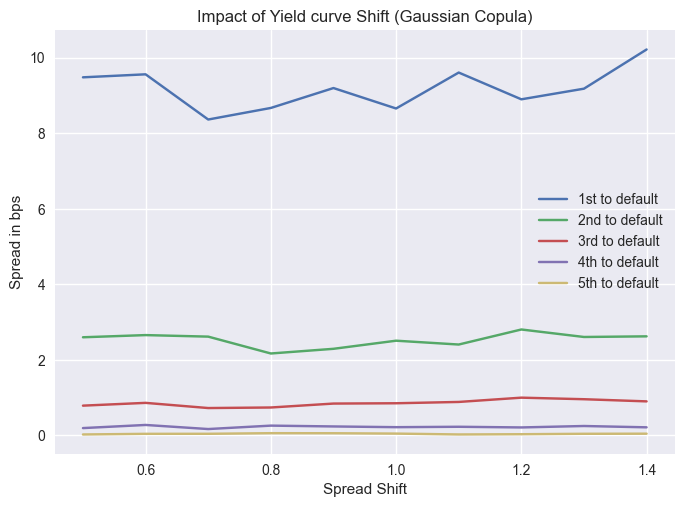

In [ ]:
spread_g = pd.DataFrame(spread_g)
spread_g.columns = ['1st to default', '2nd to default', '3rd to default', '4th to default', '5th to default']
spread_g.index = Yieldchange
spread_g.index.name = 'Spread Shift'
spread_g.plot(title = 'Impact of Yield curve Shift (Gaussian Copula)', ylabel = 'Spread in bps');